# Dynamic Asset Allocation Comparative Study
 Team Members: Charles Xu(cx2280), Gechen Shen(gs3168), Yuyang Xu(yx2761), Huarui Zhang(hz2817), Jiaqi Xi(jx2504)

In [ ]:
import numpy as np
import pandas as pd
from numpy import linalg
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize, Bounds, LinearConstraint, NonlinearConstraint, SR1
from sklearn.covariance import LedoitWolf
np.random.seed(2280)

import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import riskfolio as rp

import warnings
warnings.filterwarnings("ignore")

import plotly.express as px

## Part 1: Data Processing

In [ ]:
import pandas as pd
import yfinance as yf

In [ ]:
US_Tech_ETF = pd.read_csv('iShares_US_Technology_ETF_holdings.csv')
US_Healthcare_ETF = pd.read_csv('iShares_US_Healthcare_ETF_holdings.csv')
US_Utilities_ETF = pd.read_csv('iShares_US_Utilities_ETF.csv')

In [ ]:
US_Tech_Underlying = US_Tech_ETF[US_Tech_ETF['Asset Class'] == 'Equity'].Ticker.to_numpy()
US_Healthcare_ETF = US_Healthcare_ETF[US_Healthcare_ETF['Asset Class'] == 'Equity'].Ticker.to_numpy()
US_Utilities_ETF = US_Utilities_ETF[US_Utilities_ETF['Asset Class'] == 'Equity'].Ticker.to_numpy()

In [ ]:
def data_process(etf_symbol, underlying_stocks, start_date='2013-05-29', end_date='2023-04-28'):
    etf_data = yf.download(etf_symbol, start=start_date, end=end_date)
    stocks_data = {}
    for stock in underlying_stocks:
        stocks_data[stock] = yf.download(stock, start=start_date, end=end_date)
    etf_returns = etf_data['Adj Close'].pct_change().dropna()
    etf_returns.name = etf_symbol
    stock_returns = pd.DataFrame()
    for stock, data in stocks_data.items():
        returns = data['Adj Close'].pct_change().dropna()
        stock_returns[stock] = returns
    R = pd.concat([etf_returns, stock_returns], axis=1).T
    R = R.dropna()
    return R.to_numpy()

In [ ]:
Tech_Returns = data_process('IYW', US_Tech_Underlying)
Healthcare_Returns = data_process('IYH', US_Healthcare_ETF)
Utilities_Returns = data_process('IDU', US_Utilities_ETF)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

/var/folders/0p/c6qcj83132s_xgj86df_1npm0000gn/T/ipykernel_91598/323037319.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  stock_returns[stock] = returns
/var/folders/0p/c6qcj83132s_xgj86df_1npm0000gn/T/ipykernel_91598/323037319.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  stock_returns[stock] = returns
/var/folders/0p/c6qcj83132s_xgj86df_1npm0000gn/T/ipykernel_91598/323037319.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

/var/folders/0p/c6qcj83132s_xgj86df_1npm0000gn/T/ipykernel_91598/323037319.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  stock_returns[stock] = returns
/var/folders/0p/c6qcj83132s_xgj86df_1npm0000gn/T/ipykernel_91598/323037319.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  stock_returns[stock] = returns
/var/folders/0p/c6qcj83132s_xgj86df_1npm0000gn/T/ipykernel_91598/323037319.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
tech_returns = pd.DataFrame(Tech_Returns.T)

In [ ]:
print(Tech_Returns.shape, Healthcare_Returns.shape, Utilities_Returns.shape)

(78, 2496) (84, 2496) (40, 2496)


### -- Benchmark

### 1.3.1 “1/N” with rebalancing (ew)

In [ ]:
def ew(d, M, R, para):
    w_t = np.ones((d,1))*(1/d)
    return w_t

### 1.3.2 Market Portfolio/Factor Portfolio (mkt)

In [ ]:
def mkt(d, M, R, para):
    w_t = np.zeros((d,1))
    w_t[0] = 1
    return w_t

### 1.3.3 Sample-based mean-variance (mv)

In [ ]:
def mv(d, M, R, para):
    kappa, T, rf = para[0], para[1], para[2]
    e = np.ones((d, 1))
    mu = R.mean(axis = 1).reshape(-1,1)
    mu_2 = mu - rf * e
    cov = np.cov(R)
    w_t = (kappa - rf)/(mu_2.T @ np.linalg.inv(cov) @ mu_2) * np.linalg.inv(cov) @ mu_2
    return w_t

In [ ]:
def mean_variance_optimization(d, M, R, para):
    kappa, T, rf = para[0], para[1], para[2]
    e = np.ones((d, 1))
    mu = R.mean(axis = 1).reshape(-1,1)
    mu_2 = mu - rf * e
    cov = np.cov(R)
    w_t = (kappa - rf)/(mu_2.T @ np.linalg.inv(cov) @ mu_2) * np.linalg.inv(cov) @ mu_2
    return w_t


In [ ]:
def risk_parity_optimization(d, M, R, para):
    cov = np.cov(R)
    initial_weights = np.ones(d) / d

    def risk_objective(w):
        portfolio_variance = w @ cov @ w.T
        risk_contributions = (w * (cov @ w.T)) / portfolio_variance
        return np.sum((risk_contributions - 1/d)**2)

    bounds = Bounds(np.zeros(d), np.ones(d))
    linear_constraint = LinearConstraint(np.ones(d), 1, 1)
    
    optimized_result = minimize(risk_objective, initial_weights, constraints=linear_constraint, bounds=bounds)
    w_t = optimized_result.x.reshape(-1, 1)

    return w_t

In [ ]:
def top_bottom_performers_allocation(d, M, R, para):
    e = np.ones((d, 1))
    cumsum_returns = np.sum(R, axis=1)
    top_performers = np.argsort(cumsum_returns)[-5:]
    bottom_performers = np.argsort(cumsum_returns)[:5]
    w_t = np.zeros((d, 1))
    w_t[top_performers] = 1/5
    w_t[bottom_performers] = -1/5
    return w_t

## Added inverse_volatility_allocation, max_diversification, black_litterman
Yuyang Xu

In [ ]:
def inverse_volatility_allocation(d, M, R, para):
    vol = np.std(R, axis=1)
    inverse_vol = 1 / vol
    w_t = (inverse_vol / np.sum(inverse_vol)).reshape(-1, 1)
    return w_t

In [ ]:
def max_diversification(d, M, R, para):
    cov = np.cov(R)
    initial_weights = np.ones(d) / d

    def negative_diversification_ratio(w):
        portfolio_volatility = np.sqrt(w @ cov @ w.T)
        weighted_individual_volatility = w * np.sqrt(np.diag(cov))
        diversification_ratio = weighted_individual_volatility.sum() / portfolio_volatility
        return -diversification_ratio

    bounds = Bounds(np.zeros(d), np.ones(d))
    linear_constraint = LinearConstraint(np.ones(d), 1, 1)

    optimized_result = minimize(negative_diversification_ratio, initial_weights, constraints=linear_constraint, bounds=bounds)
    w_t = optimized_result.x.reshape(-1, 1)

    return w_t

In [ ]:
def black_litterman_sma20(d, M, R, para):
    # Market capitalization weights
    market_cap = np.sum(R, axis=1).reshape(-1, 1)
    market_cap_weights = market_cap / np.sum(market_cap)

    # Prior return estimate
    # Technical indicator-based prior return estimates
    R_df = pd.DataFrame(R.T)
    prior_return = R_df.rolling(window=20).mean().iloc[-1].values.reshape(-1, 1)

    # Covariance matrix
    cov = LedoitWolf().fit(R.T).covariance_

    # Black-Litterman parameters
    tau = 0.05
    delta = 2.5

    # Compute equilibrium excess returns
    market_return = np.dot(market_cap_weights.T, prior_return)
    excess_market_return = market_return - para[2]
    omega = np.diag(np.diag(cov))
    pi = delta * np.dot(omega, market_cap_weights) * excess_market_return / tau

    # Compute posterior estimate of returns
    posterior_cov = np.linalg.inv(np.linalg.inv(tau * omega) + np.dot(np.dot(market_cap_weights.T, np.linalg.inv(cov)), market_cap_weights))
    posterior_return = np.dot(posterior_cov, (np.dot(np.linalg.inv(tau * omega), pi) + np.dot(np.dot(np.linalg.inv(cov), market_cap_weights), market_return)))

    # Compute optimal portfolio weights
    bounds = [(0, 1) for i in range(d)]
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    optimized_result = minimize(lambda w: -np.dot(w.T, posterior_return) / (np.sqrt(np.dot(np.dot(w.T, posterior_cov), w))), x0=np.ones(d) / d, bounds=bounds, constraints=constraints)
    w_t = optimized_result.x.reshape(-1, 1)

    return w_t

In [ ]:
def black_litterman_sma50(d, M, R, para):
    # Market capitalization weights
    market_cap = np.sum(R, axis=1).reshape(-1, 1)
    market_cap_weights = market_cap / np.sum(market_cap)

    # Prior return estimate
    # Technical indicator-based prior return estimates
    R_df = pd.DataFrame(R.T)
    prior_return = R_df.rolling(window=50).mean().iloc[-1].values.reshape(-1, 1)

    # Covariance matrix
    cov = LedoitWolf().fit(R.T).covariance_

    # Black-Litterman parameters
    tau = 0.05
    delta = 2.5

    # Compute equilibrium excess returns
    market_return = np.dot(market_cap_weights.T, prior_return)
    excess_market_return = market_return - para[2]
    omega = np.diag(np.diag(cov))
    pi = delta * np.dot(omega, market_cap_weights) * excess_market_return / tau

    # Compute posterior estimate of returns
    posterior_cov = np.linalg.inv(np.linalg.inv(tau * omega) + np.dot(np.dot(market_cap_weights.T, np.linalg.inv(cov)), market_cap_weights))
    posterior_return = np.dot(posterior_cov, (np.dot(np.linalg.inv(tau * omega), pi) + np.dot(np.dot(np.linalg.inv(cov), market_cap_weights), market_return)))

    # Compute optimal portfolio weights
    bounds = [(0, 1) for i in range(d)]
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    optimized_result = minimize(lambda w: -np.dot(w.T, posterior_return) / (np.sqrt(np.dot(np.dot(w.T, posterior_cov), w))), x0=np.ones(d) / d, bounds=bounds, constraints=constraints)
    w_t = optimized_result.x.reshape(-1, 1)

    return w_t

In [ ]:
def black_litterman_rsi(d, M, R, para):
    # Market capitalization weights
    market_cap = np.sum(R, axis=1).reshape(-1, 1)
    market_cap_weights = market_cap / np.sum(market_cap)

    # Prior return estimate
    # Technical indicator-based prior return estimates
    R_df = pd.DataFrame(R.T)
    prior_return = ((R_df > 0).rolling(window=14).sum() / 14).iloc[-1].values.reshape(-1, 1)

    # Covariance matrix
    cov = LedoitWolf().fit(R.T).covariance_

    # Black-Litterman parameters
    tau = 0.05
    delta = 2.5

    # Compute equilibrium excess returns
    market_return = np.dot(market_cap_weights.T, prior_return)
    excess_market_return = market_return - para[2]
    omega = np.diag(np.diag(cov))
    pi = delta * np.dot(omega, market_cap_weights) * excess_market_return / tau

    # Compute posterior estimate of returns
    posterior_cov = np.linalg.inv(np.linalg.inv(tau * omega) + np.dot(np.dot(market_cap_weights.T, np.linalg.inv(cov)), market_cap_weights))
    posterior_return = np.dot(posterior_cov, (np.dot(np.linalg.inv(tau * omega), pi) + np.dot(np.dot(np.linalg.inv(cov), market_cap_weights), market_return)))

    # Compute optimal portfolio weights
    bounds = [(0, 1) for i in range(d)]
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    optimized_result = minimize(lambda w: -np.dot(w.T, posterior_return) / (np.sqrt(np.dot(np.dot(w.T, posterior_cov), w))), x0=np.ones(d) / d, bounds=bounds, constraints=constraints)
    w_t = optimized_result.x.reshape(-1, 1)

    return w_t

In [ ]:
def black_litterman_macd(d, M, R, para):
    # Market capitalization weights
    market_cap = np.sum(R, axis=1).reshape(-1, 1)
    market_cap_weights = market_cap / np.sum(market_cap)

    # Prior return estimate
    # Technical indicator-based prior return estimates
    R_df = pd.DataFrame(R.T)
    prior_return = (R_df.ewm(span=12, adjust=False).mean() - R_df.ewm(span=26, adjust=False).mean()).iloc[-1].values.reshape(-1, 1)

    # Covariance matrix
    cov = LedoitWolf().fit(R.T).covariance_

    # Black-Litterman parameters
    tau = 0.05
    delta = 2.5

    # Compute equilibrium excess returns
    market_return = np.dot(market_cap_weights.T, prior_return)
    excess_market_return = market_return - para[2]
    omega = np.diag(np.diag(cov))
    pi = delta * np.dot(omega, market_cap_weights) * excess_market_return / tau

    # Compute posterior estimate of returns
    posterior_cov = np.linalg.inv(np.linalg.inv(tau * omega) + np.dot(np.dot(market_cap_weights.T, np.linalg.inv(cov)), market_cap_weights))
    posterior_return = np.dot(posterior_cov, (np.dot(np.linalg.inv(tau * omega), pi) + np.dot(np.dot(np.linalg.inv(cov), market_cap_weights), market_return)))

    # Compute optimal portfolio weights
    bounds = [(0, 1) for i in range(d)]
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    optimized_result = minimize(lambda w: -np.dot(w.T, posterior_return) / (np.sqrt(np.dot(np.dot(w.T, posterior_cov), w))), x0=np.ones(d) / d, bounds=bounds, constraints=constraints)
    w_t = optimized_result.x.reshape(-1, 1)

    return w_t

In [ ]:
# totally random case
def black_litterman(d, M, R, para):
    # Market capitalization weights
    market_cap = np.random.rand(d, 1)
    market_cap_weights = market_cap / np.sum(market_cap)

    # Prior return estimate and covariance matrix
    prior_return = np.random.uniform(-1, 1, size = (d, 1))
    #prior_return = R.mean(axis=1).reshape(d, 1)
    
    cov = LedoitWolf().fit(R.T).covariance_

    # Black-Litterman parameters
    tau = 0.05
    delta = 2.5

    # Compute equilibrium excess returns
    market_return = np.dot(market_cap_weights.T, prior_return)
    excess_market_return = market_return - para[2]
    omega = np.diag(np.diag(cov))
    pi = delta * np.dot(omega, market_cap_weights) * excess_market_return / tau

    # Compute posterior estimate of returns
    posterior_cov = np.linalg.inv(np.linalg.inv(tau * omega) + np.dot(np.dot(market_cap_weights.T, np.linalg.inv(cov)), market_cap_weights))
    posterior_return = np.dot(posterior_cov, (np.dot(np.linalg.inv(tau * omega), pi) + np.dot(np.dot(np.linalg.inv(cov), market_cap_weights), market_return)))

    # Compute optimal portfolio weights
    bounds = [(0, 1) for i in range(d)]
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    optimized_result = minimize(lambda w: -np.dot(w.T, posterior_return) / (np.sqrt(np.dot(np.dot(w.T, posterior_cov), w))), x0=np.ones((d, 1)) / d, bounds=bounds, constraints=constraints)
    w_t = optimized_result.x.reshape(-1, 1)

    return w_t

In [ ]:
def rp_closed(d, M, R, para):
    covariance = np.cov(R)

    #Calculate the volatility of each asset's returns
    volatility = np.sqrt(np.diag(covariance))
#     risk_contribution = np.dot(covariance, 1/volatility) / np.dot(1/volatility, 1/volatility)
#     w = risk_contribution / np.sum(risk_contribution)
#     #Normalizing
#     w /= np.sum(w)
    w = np.dot(covariance, 1/volatility) / np.sum(np.dot(covariance, 1/volatility))
    

    d = R.shape[0]
    w_t = w.reshape(d,1)
    return w_t

In [ ]:
def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = pd.concat([sortIx, df0], axis=0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_matrix = cov.loc[cItems,cItems] # matrix slice
    asset_variances = np.diag(cov_matrix)
    # calculate the vector of asset weights
    iv_weights = 1 / asset_variances
    iv_weights /= np.sum(iv_weights)
    
    w_ = iv_weights.reshape(-1,1)
    clusVar = np.dot(np.dot(w_.T,cov_matrix),w_)[0,0]
    return clusVar

def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            clusVar0 = getClusterVar(cov, cItems0)
            clusVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - clusVar0 / (clusVar0 + clusVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w
def hrp(d, M, R, para):
    d = R.shape[0]

    # Construct a hierarchical portfolio
    returns = pd.DataFrame(R.T)
    cov_matrix = returns.cov()
    corr_matrix = returns.corr()
    distance_matrix = np.sqrt((1 - corr_matrix) / 2)

    # Compute the linkage using ward method
    linkage_matrix = linkage(distance_matrix, method='ward')
    sortIx = getQuasiDiag(linkage_matrix)
    sortIx = corr_matrix.index[sortIx].tolist()
    w_t = getRecBipart(cov_matrix, sortIx).values.reshape(-1,1)
    return w_t

In [ ]:
def nco(d, M, R, para):
    # Building the portfolio object
    data = pd.DataFrame(R.T)
    port = rp.HCPortfolio(returns=data)
    kappa, T, rf = para[0], para[1], para[2]
    
    # Estimate optimal portfolio:

    model='NCO' # Could be HRP, HERC or NCO
    codependence = 'pearson' # Correlation matrix used to group assets in clusters
    covariance = 'hist' # Covariance estimation technique
    obj = "MinRisk" # Posible values are "MinRisk", "Utility", "Sharpe" and "ERC"
    rm = 'MV' # Risk measure used, this time will be variance
    # rf = 0 # Risk free rate
    l = 2 # Risk aversion factor, only usefull with "Utility" objective
    linkage = 'ward' # Linkage method used to build clusters
    max_k = 10 # Max number of clusters used in two difference gap statistic
    leaf_order = True # Consider optimal order of leafs in dendrogram

    w = port.optimization(model=model,
                        codependence=codependence,
                        covariance=covariance,
                        obj=obj,
                        rm=rm,
                        rf=rf,
                        l=l,
                        linkage=linkage,
                        max_k=max_k,
                        leaf_order=leaf_order)

    return w.to_numpy().reshape(d, 1)

In [ ]:
def herc(d, M, R, para):
    data = pd.DataFrame(R.T)
    kappa, T, rf = para[0], para[1], para[2]

    # Building the portfolio object
    port = rp.HCPortfolio(returns=data)

    # Estimate optimal portfolio:

    model = 'HERC' # Could be HRP, HERC or NCO
    codependence = 'pearson' # Correlation matrix used to group assets in clusters
    rm = 'MV' # Risk measure used, this time will be variance
    linkage = 'ward' # Linkage method used to build clusters
    max_k = 10 # Max number of clusters used in two difference gap statistic
    leaf_order = True # Consider optimal order of leafs in dendrogram

    w = port.optimization(model=model,
                        codependence=codependence,
                        rm=rm,
                        rf=rf,
                        linkage=linkage,
                        max_k=max_k,
                        leaf_order=leaf_order)

    return w.to_numpy().reshape(d, 1)
        

In [ ]:
def ewma(d, M, R, para):
    lamda, rf = para[0], para[2]
    e = np.ones((d, 1))
    mu = R.mean(axis = 1).reshape(-1,1)
    mu_2 = mu - rf * e
    cov = np.cov(R)
    w_prev = np.ones((d,1))*(1/d)
    w_t = w_prev
    for i in range(M):
        w_prev = w_t
        w_t = lamda * np.linalg.inv(cov+np.eye(d)*0.00001) @ mu_2 + (1 - lamda) * w_prev
    return w_t

In [ ]:
from sklearn.covariance import LedoitWolf

def ewma_regularized(d, M, R, para):
    lamda, rf = para[0], para[2]
    e = np.ones((d, 1))
    mu = R.mean(axis = 1).reshape(-1,1)
    mu_2 = mu - rf * e
    regularized_cov = LedoitWolf().fit(R.T).covariance_
    w_prev = np.ones((d,1))*(1/d)
    w_t = w_prev
    for i in range(M):
        w_prev = w_t
        w_t = lamda * np.linalg.inv(regularized_cov) @ mu_2 + (1 - lamda) * w_prev
    return w_t

In [ ]:
def onef(d, M, R, para):
    kappa, T, rf = para[0], para[1], para[2]
    e = np.ones((d, 1))
    mu = np.array([np.mean(R, axis=1)]).T
    mu_2 = mu - rf * e
    B_hat = np.zeros((d, 1))
    res = np.zeros((d, M))
    X = sm.add_constant(R[0] - rf)
    for j in range(d):
        Y = R[j] - rf
        model = sm.OLS(Y, X).fit()
        B_hat[j, 0] = model.params[1]
        res[j, :] = model.resid
    res[0, :] = 0
    cov_R = np.var(R[0])
    sig = np.cov(res)
    cov = B_hat @ B_hat.T * cov_R + sig
    w_t = (kappa - rf)/(mu_2.T @ np.linalg.inv(cov) @ mu_2) * np.linalg.inv(cov) @ mu_2
    return w_t

In [ ]:
def bs(d, M, R, para):
    kappa, T, rf = para[0], para[1], para[2]
    e = np.ones((d, 1))
    mu = R.mean(axis = 1).reshape(-1,1)
    cov = np.cov(R)
    mu_0 = (mu.T @ np.linalg.inv(cov) @ e) / (e.T @ np.linalg.inv(cov) @ e) * e
    a = (d + 2) / (d + 2 + (M - d - 2) * (mu - mu_0).T @ np.linalg.inv(cov) @ (mu - mu_0))
    mu_1 = (1 - a) * (mu - mu_0) + mu_0
    mu_2 = mu_1 - rf * e
    w_t = (kappa - rf)/(mu_2.T @ np.linalg.inv(cov) @ mu_2) * np.linalg.inv(cov) @ mu_2
    return w_t

In [ ]:
def lw(d, M, R, para):
    kappa, T, rf = para[0], para[1], para[2]
    e = np.ones((d, 1))
    mu = R.mean(axis = 1).reshape(-1,1)
    mu_2 = mu - rf * e
    Ledoit = LedoitWolf().fit(R.T)
    cov = Ledoit.covariance_
    w_t = (kappa - rf)/(mu_2.T @ np.linalg.inv(cov) @ mu_2) * np.linalg.inv(cov) @ mu_2
    return w_t

In [ ]:
def min(d, M, R, para):
    e = np.ones((d, 1))
    mu = R.mean(axis = 1).reshape(-1,1)
    cov = np.cov(R)
    w_t = 1/(e.T @ np.linalg.inv(cov) @ e) * np.linalg.inv(cov) @ e
    return w_t

In [ ]:
 def mv_c(d, M, R, para): 
    kappa, T, rf = para[0], para[1], para[2]
    e = np.ones((d, 1))
    mu = R.mean(axis = 1)
    cov = np.cov(R)
    def objective(w_t, cov): 
        return w_t.T @ cov @ w_t
    
    result = minimize(objective, np.ones(d) / d, args = (cov,),
        constraints=[LinearConstraint(mu-rf, kappa-rf, np.inf),LinearConstraint(np.ones(d), 1, 1)], bounds=Bounds(np.zeros(d), np.inf))
    w_t = result.x.reshape(d,1)
    return w_t

In [ ]:
def bs_c(d, M, R, para):
    kappa, T, rf = para[0], para[1], para[2]
    e = np.ones((d, 1))
    mu = R.mean(axis = 1).reshape(-1,1)
    cov = np.cov(R)
    mu_0 = (mu.T @ np.linalg.inv(cov) @ e) / (e.T @ np.linalg.inv(cov) @ e) * e
    a = (d + 2) / (d + 2 + (M - d - 2) * (mu - mu_0).T @ np.linalg.inv(cov) @ (mu - mu_0))
    mu_1 = (1 - a) * (mu - mu_0) + mu_0
    def objective(w_t, cov): 
        return w_t.T @ cov @ w_t
    result = minimize(objective, np.ones(d) / d, args = (cov,),
        constraints=[LinearConstraint(mu_1.reshape(d) - rf, kappa-rf, np.inf),LinearConstraint(np.ones(d), 1, 1)], bounds=Bounds(np.zeros(d), np.inf))
    w_t = result.x.reshape(d,1)
    return w_t

In [ ]:
def lw_c(d, M, R, para):
    kappa, T, rf = para[0], para[1], para[2]
    e = np.ones((d, 1))
    mu = R.mean(axis = 1)
    mu_2 = mu - rf
    Ledoit = LedoitWolf().fit(R.T)
    cov = Ledoit.covariance_
    def objective(w_t, cov): 
        return w_t.T @ cov @ w_t
    result = minimize(objective, np.ones(d) / d, args = cov, 
        constraints=[LinearConstraint(mu_2, kappa-rf, np.inf),LinearConstraint(np.ones(d), 1, 1)], bounds=Bounds(np.zeros(d), np.inf))
    w_t = result.x.reshape(d,1)
    return w_t

In [ ]:
def min_c(d, M, R, para):
    e = np.ones((d, 1))
    mu = R.mean(axis = 1).reshape(-1,1)
    cov = np.cov(R)
    def objective(w_t, cov): 
        return w_t.T @ cov @ w_t
    result = minimize(objective, np.ones(d) / d, args=cov,
        constraints=[LinearConstraint(e.reshape(d), 1.0, 1.0)], bounds=Bounds(np.zeros(d), np.ones(d)))
    w_t = result.x.reshape(d,1)
    return w_t

In [ ]:
def kalman_filter_single_asset(R):
    A = np.array([[1, 1], [0, 1]])
    H = np.array([[1, 0]])
    Q = np.array([[0.1, 0], [0, 0.1]])
    R_matrix = np.array([[1]])
    x = np.array([[0], [0]])
    P = np.array([[1, 0], [0, 1]])
    filtered_returns = np.zeros(R.shape[0])
    for j in range(R.shape[0]):
        y = R[j]
        x = np.dot(A, x)
        P = np.dot(np.dot(A, P), A.T) + Q
        K = np.dot(np.dot(P, H.T), np.linalg.inv(np.dot(np.dot(H, P), H.T) + R_matrix))
        x = x + np.dot(K, (y - np.dot(H, x)))
        P = np.dot((np.eye(2) - np.dot(K, H)), P)
        filtered_returns[j] = x[0]
    return filtered_returns

def calculate_filtered_returns(R):
    d = R.shape[0]
    filtered_returns = np.zeros(R.shape)
    for i in range(d):
        filtered_returns[i] = kalman_filter_single_asset(R[i])
    return filtered_returns

def kalman_filter_allocation(d, M, R, para):
    w_t = mv(d, M, R, para)
    return w_t

## 1.4 Performance Metrics

### 1.4.1 Out-of-sample average return (ORtn): $\hat{\mu}_{OOS}$

In [ ]:
def ORtn(w, d, R, M, rf):
    e = np.ones((d, 1))
    X_t = rf + (R[:, M:] - rf * e).T @ w
    return np.mean(np.diag(X_t))

### 1.4.2 Out-of-sample Sharpe ratio OSR = $\frac{\hat{\mu}_{OOS} - r}{\hat{\sigma}_{OOS}}$

In [ ]:
def OSR(w, d, R, M, rf):
    e = np.ones((d, 1))
    X_t = rf + (R[:, M:] - rf * e).T @ w
    return (np.mean(np.diag(X_t)) - rf)/np.std(np.diag(X_t))

### 1.4.3 Out-of-sample Sortino ratio OSSortino

In [ ]:
def OSSortino(w, d, R, M, rf, target=0):
    e = np.ones((d, 1))
    X_t = rf + (R[:, M:] - rf * e).T @ w

    # Calculate downside deviations
    downside_diff = np.minimum(X_t - target, 0)
    downside_std = np.sqrt(np.mean(np.diag(downside_diff)**2))

    # Calculate Sortino ratio
    sortino_ratio = (np.mean(np.diag(X_t)) - rf) / downside_std

    return sortino_ratio

### 1.4.4 Out-of-sample Max Drawdown

In [ ]:
def OMaxDrawdown(w, d, R, M, rf):
    e = np.ones((d, 1))
    X_t = rf + (R[:, M:] - rf * e).T @ w

    # Calculate the cumulative returns
    cum_returns = np.cumprod(1 + np.diag(X_t))

    # Calculate the running maximum
    running_max = np.maximum.accumulate(cum_returns)

    # Calculate drawdowns and find the maximum drawdown
    drawdowns = 1 - cum_returns / running_max
    max_drawdown = np.max(drawdowns)

    return max_drawdown


### 1.4.4 Out-of-sample Calmar Ratio

In [ ]:
def OCalmarRatio(w, d, R, M, rf):
    e = np.ones((d, 1))
    X_t = rf + (R[:, M:] - rf * e).T @ w

    # Calculate the average annual return
    avg_annual_return = np.mean(np.diag(X_t)) * 252

    # Calculate the cumulative returns
    cum_returns = np.cumprod(1 + np.diag(X_t))

    # Calculate the running maximum
    running_max = np.maximum.accumulate(cum_returns)

    # Calculate drawdowns and find the maximum drawdown
    drawdowns = 1 - cum_returns / running_max
    max_drawdown = np.max(drawdowns)

    # Calculate the Calmar Ratio
    calmar_ratio = avg_annual_return / max_drawdown

    return calmar_ratio

### 1.4.5 Out-of-sample Average Turnover Ratio

In [ ]:
def OTurnoverRatio(w, d, R, M, rf, rebalancing_frequency=1):
    e = np.ones((d, 1))
    X_t = rf + (R[:, M:] - rf * e).T @ w

    # Calculate the number of periods
    n_periods = X_t.shape[1]

    # Calculate the number of rebalancing events
    n_rebalancing = int(n_periods / rebalancing_frequency)

    # Select the portfolio weights at the start of each rebalancing period
    start_indices = np.arange(0, n_periods - rebalancing_frequency, rebalancing_frequency)
    end_indices = start_indices + rebalancing_frequency
    w_start = w[:, start_indices]
    w_end = w[:, end_indices]

    # Calculate the turnover for each rebalancing period
    turnovers = np.sum(np.abs(w_end - w_start), axis=0)

    # Calculate the average turnover ratio
    avg_turnover_ratio = np.mean(turnovers)

    return avg_turnover_ratio


## 1.5 Performance 

In [ ]:
def get_weights(d, M, R, method, para): 
    return eval(method)(d, M, R, para)

def performance(M, R, kappa, rf):
    methods_name = [ 'ew', 'mkt', \
                    "inverse_volatility_allocation",\
                    'black_litterman','black_litterman_macd','black_litterman_rsi',\
                    'rp_closed','risk_parity_optimization',\
                    'herc'
                   ]
#     methods_name = [ 'ew', 'mkt', "inverse_volatility_allocation",'black_litterman']
#    methods_name = [ 'ew', 'mkt', 'inverse_volatility_allocation','equal_risk_contribution','global_minimum_variance_portfolio']
#     'kalman_filter_allocation']
#     methods_name = ['ew', 'mkt', 'min_c', 'risk_parity_optimization']
#     methods_name = ['theory', 'ew', 'mkt', 'mv', 'onef', 'bs', 'lw', 'min', 'mv_c', 'bs_c', 'lw_c', 'min_c']
#     kappa, T, rf, exp = para[0], para[1], para[2], para[3]
#     d, M, R, B, sigma, alpha = generate_data(exp)
    d, T = R.shape
#     R_new = calculate_filtered_returns(R)
#   21, 63, 126, 252

    para = [kappa, T, rf]
    results_df = pd.DataFrame(columns=['method', 'ortn', 'osr', 'ossortino', 'omaxdrawdown','ocalmarratio', 'oturnoverratio'])
    for method in methods_name:
        w = np.zeros((d, T - M))
        for i in range(0, T - M):
            R_M = R[:, i:i+M]
            if method == 'kalman_filter_allocation':
#                 print(1)
                w_t = kalman_filter_allocation(d, M, R_M[:, i:i+M], para)
#                 print(w_t)
            else:
                w_t = get_weights(d, M, R_M, method, para)
            w[:,[i]] = w_t
        ortn = ORtn(w, d, R, M, rf)
        osr = OSR(w, d, R, M, rf)
        ossortino = OSSortino(w, d, R, M, rf, kappa)
        omaxdrawdown = OMaxDrawdown(w, d, R, M, rf)
        ocalmarratio = OCalmarRatio(w, d, R, M, rf)
        oturnoverratio = OTurnoverRatio(w, d, R, M, rf)
        results_df = results_df.append({'method': method, \
                                        'ortn': ortn, \
                                        'osr': osr, \
                                        'ossortino': ossortino, \
                                        'omaxdrawdown': omaxdrawdown, \
                                        'ocalmarratio':ocalmarratio,\
                                        'oturnoverratio':oturnoverratio}, ignore_index=True)
        print(method, ortn, osr)
    display(results_df)
    return results_df

### M = 21

In [ ]:
M = 21
kappa = 0.3/252
rf = 0.002/21
perf_tech_21 = performance(M, Tech_Returns, kappa, rf)
perf_heal_21 = performance(M, Healthcare_Returns, kappa, rf)
perf_util_21 = performance(M, Utilities_Returns, kappa, rf)

ew 0.0008651412824273943 0.05175583470479078
mkt 0.0007938890556263797 0.04744583019650232
inverse_volatility_allocation 0.000836894425268883 0.05302218711254829
black_litterman 0.0009944975374804332 0.05932558738059014
black_litterman_macd 0.0008303495329624431 0.04742116613203672
black_litterman_rsi 0.0009454374906947802 0.05515767533213805
rp_closed 0.0009039284936671028 0.04976456588948612
risk_parity_optimization 0.0008143461387101554 0.05274975353722342
herc 0.0007976258312863582 0.05324120440776111


,method,ortn,osr,ossortino,omaxdrawdown,ocalmarratio,oturnoverratio
0,ew,0.000865,0.051756,0.069463,0.357168,0.610401,0.000000
1,mkt,0.000794,0.047446,0.063896,0.394362,0.507301,0.000000
2,inverse_volatility_allocation,0.000837,0.053022,0.070843,0.350750,0.601276,0.039951
3,black_litterman,0.000994,0.059326,0.080516,0.341271,0.734353,1.383059
4,black_litterman_macd,0.000830,0.047421,0.064176,0.398216,0.525463,0.923643
5,black_litterman_rsi,0.000945,0.055158,0.074694,0.400571,0.594777,0.376269
6,rp_closed,0.000904,0.049765,0.067129,0.368949,0.617402,0.063595
7,risk_parity_optimization,0.000814,0.052750,0.070386,0.349029,0.587960,0.096411
8,herc,0.000798,0.053241,0.071752,0.328508,0.611862,0.867195


ew 0.0008114385415213052 0.0581135704084695
mkt 0.0005232460225117174 0.039279090350386264
inverse_volatility_allocation 0.0007460775436861689 0.05740773964877158
black_litterman 0.0008219328836775652 0.05468087582316922
black_litterman_macd 0.000908884364689351 0.05925222993927023
black_litterman_rsi 0.0008478447863525311 0.054717158728281035
rp_closed 0.0008078575513958066 0.05073397066797038
risk_parity_optimization 0.000781108071794572 0.06090793888776373
herc 0.0007433322767346053 0.05714162252135802


,method,ortn,osr,ossortino,omaxdrawdown,ocalmarratio,oturnoverratio
0,ew,0.000811,0.058114,0.077598,0.305917,0.668424,0.000000
1,mkt,0.000523,0.039279,0.052000,0.284031,0.464238,0.000000
2,inverse_volatility_allocation,0.000746,0.057408,0.076077,0.304335,0.617779,0.041360
3,black_litterman,0.000822,0.054681,0.073449,0.313962,0.659721,1.397354
4,black_litterman_macd,0.000909,0.059252,0.081390,0.257839,0.888301,0.875920
5,black_litterman_rsi,0.000848,0.054717,0.074724,0.309590,0.690129,0.363478
6,rp_closed,0.000808,0.050734,0.068376,0.326151,0.624190,0.080565
7,risk_parity_optimization,0.000781,0.060908,0.081032,0.300712,0.654577,0.115425
8,herc,0.000743,0.057142,0.076086,0.295888,0.633076,0.923070


ew 0.0004761867940231751 0.032809456050597305
mkt 0.0004261265197495062 0.028203802089015878
inverse_volatility_allocation 0.0004671893100814236 0.032402180887596894
black_litterman 0.00048015662866483837 0.03321125639788524
black_litterman_macd 0.0005195425716949832 0.03377545666653067
black_litterman_rsi 0.00040723405612321927 0.025729247361923613
rp_closed 0.0005501697983903442 0.037426370900780506
risk_parity_optimization 0.00043642422922784524 0.030084186273240464
herc 0.00045998115427553856 0.03187554572143271


,method,ortn,osr,ossortino,omaxdrawdown,ocalmarratio,oturnoverratio
0,ew,0.000476,0.032809,0.043370,0.368557,0.325592,0.000000
1,mkt,0.000426,0.028204,0.037261,0.361798,0.296806,0.000000
2,inverse_volatility_allocation,0.000467,0.032402,0.042823,0.368905,0.319138,0.030904
3,black_litterman,0.000480,0.033211,0.043777,0.347748,0.347951,1.366300
4,black_litterman_macd,0.000520,0.033775,0.044520,0.428670,0.305421,0.965603
5,black_litterman_rsi,0.000407,0.025729,0.033745,0.381376,0.269086,0.441675
6,rp_closed,0.000550,0.037426,0.049922,0.361634,0.383379,0.048134
7,risk_parity_optimization,0.000436,0.030084,0.039672,0.376374,0.292207,0.063387
8,herc,0.000460,0.031876,0.041882,0.387633,0.299033,0.667098


### M = 63

In [ ]:
M = 63
kappa = 0.3/252
rf = 0.002/21
perf_tech_63 = performance(M, Tech_Returns, kappa, rf)
perf_heal_63 = performance(M, Healthcare_Returns, kappa, rf)
perf_util_63 = performance(M, Utilities_Returns, kappa, rf)

ew 0.0008567618235051605 0.05088692907106489
mkt 0.0007907047366075001 0.046931272312568925
inverse_volatility_allocation 0.0008228119691783035 0.051536600037495814
black_litterman 0.0008972528460893695 0.05357977337018679
black_litterman_macd 0.0006924948113837744 0.03964121208215481
black_litterman_rsi 0.001002773086141216 0.05779143154333199
rp_closed 0.0008936698541823231 0.04911062044352832
risk_parity_optimization 0.0008309019396292729 0.05368650949655725
herc 0.0009074034137372522 0.059068737951763414


,method,ortn,osr,ossortino,omaxdrawdown,ocalmarratio,oturnoverratio
0,ew,0.000857,0.050887,0.068297,0.357168,0.604489,0.000000
1,mkt,0.000791,0.046931,0.063230,0.394362,0.505266,0.000000
2,inverse_volatility_allocation,0.000823,0.051537,0.068834,0.348953,0.594203,0.012566
3,black_litterman,0.000897,0.053580,0.071981,0.365629,0.618408,1.375248
4,black_litterman_macd,0.000692,0.039641,0.052731,0.372951,0.467913,0.593628
5,black_litterman_rsi,0.001003,0.057791,0.079044,0.407318,0.620397,0.223502
6,rp_closed,0.000894,0.049111,0.066274,0.369283,0.609843,0.018804
7,risk_parity_optimization,0.000831,0.053687,0.071646,0.348199,0.601345,0.022562
8,herc,0.000907,0.059069,0.079635,0.337728,0.677070,0.709484


ew 0.000799720702398694 0.056863494554335356
mkt 0.0005212946232112064 0.038883339647912324
inverse_volatility_allocation 0.0007340553613042572 0.05591025434590352
black_litterman 0.0007282633426219657 0.0518049257235896
black_litterman_macd 0.0009940507428897888 0.06832135337017604
black_litterman_rsi 0.0009356331031011949 0.06184176129805461
rp_closed 0.0008337025589605048 0.052916250112329165
risk_parity_optimization 0.0007624895962649516 0.05893709460312157
herc 0.0006504113589377297 0.046086062958617564


,method,ortn,osr,ossortino,omaxdrawdown,ocalmarratio,oturnoverratio
0,ew,0.000800,0.056863,0.075908,0.305917,0.658772,0.000000
1,mkt,0.000521,0.038883,0.051495,0.284031,0.462506,0.000000
2,inverse_volatility_allocation,0.000734,0.055910,0.074045,0.306405,0.603717,0.013209
3,black_litterman,0.000728,0.051805,0.069105,0.313513,0.585374,1.380424
4,black_litterman_macd,0.000994,0.068321,0.093558,0.265533,0.943390,0.545037
5,black_litterman_rsi,0.000936,0.061842,0.084758,0.288555,0.817103,0.222355
6,rp_closed,0.000834,0.052916,0.071346,0.326906,0.642670,0.024548
7,risk_parity_optimization,0.000762,0.058937,0.078181,0.287254,0.668911,0.026372
8,herc,0.000650,0.046086,0.060072,0.361545,0.453343,0.758860


ew 0.00048167353093291873 0.03312009418888224
mkt 0.0004351151235592921 0.028828983342894427
inverse_volatility_allocation 0.00047819027051131796 0.03312834286587052
black_litterman 0.0005449236701293961 0.03811683575271699
black_litterman_macd 0.000516446646270942 0.034028320259497626
black_litterman_rsi 0.0005636762240594835 0.038450420625107624
rp_closed 0.0005614732570416985 0.038944276594725026
risk_parity_optimization 0.0004439466500782008 0.03052588494960483
herc 0.0004686158980289957 0.03268060672164317


,method,ortn,osr,ossortino,omaxdrawdown,ocalmarratio,oturnoverratio
0,ew,0.000482,0.033120,0.043786,0.368557,0.329344,0.000000
1,mkt,0.000435,0.028829,0.038100,0.361798,0.303067,0.000000
2,inverse_volatility_allocation,0.000478,0.033128,0.043824,0.366452,0.328840,0.009939
3,black_litterman,0.000545,0.038117,0.051091,0.335204,0.409663,1.357051
4,black_litterman_macd,0.000516,0.034028,0.045383,0.424491,0.306590,0.583333
5,black_litterman_rsi,0.000564,0.038450,0.052294,0.319099,0.445148,0.269033
6,rp_closed,0.000561,0.038944,0.051770,0.364111,0.388593,0.014915
7,risk_parity_optimization,0.000444,0.030526,0.040339,0.372556,0.300289,0.016915
8,herc,0.000469,0.032681,0.043256,0.343670,0.343618,0.402566


### M = 126

In [ ]:
M = 126
kappa = 0.3/252
rf = 0.002/21
perf_tech_126 = performance(M, Tech_Returns, kappa, rf)
perf_heal_126 = performance(M, Healthcare_Returns, kappa, rf)
perf_util_126 = performance(M, Utilities_Returns, kappa, rf)

ew 0.0008304443261876551 0.048682848575233896
mkt 0.0007741525741897432 0.04535369529264044
inverse_volatility_allocation 0.000789100665596077 0.048613074516168885
black_litterman 0.000812186014241688 0.04787967275912856
black_litterman_macd 0.0007594314559538519 0.04385840733850396
black_litterman_rsi 0.0008977844936171977 0.05135743273401341
rp_closed 0.0008782358139451605 0.04796871138664548
risk_parity_optimization 0.0007906787400949837 0.05001227471297807
herc 0.00092222613986985 0.05805577831210956


,method,ortn,osr,ossortino,omaxdrawdown,ocalmarratio,oturnoverratio
0,ew,0.000830,0.048683,0.065298,0.357168,0.585920,0.000000
1,mkt,0.000774,0.045354,0.061072,0.394362,0.494689,0.000000
2,inverse_volatility_allocation,0.000789,0.048613,0.064877,0.347572,0.572121,0.006231
3,black_litterman,0.000812,0.047880,0.064358,0.341410,0.599487,1.375954
4,black_litterman_macd,0.000759,0.043858,0.058513,0.358539,0.533768,0.547068
5,black_litterman_rsi,0.000898,0.051357,0.069477,0.375041,0.603246,0.167266
6,rp_closed,0.000878,0.047969,0.064709,0.366161,0.604421,0.009058
7,risk_parity_optimization,0.000791,0.050012,0.066667,0.347893,0.572736,0.010146
8,herc,0.000922,0.058056,0.079345,0.303439,0.765891,0.580029


ew 0.0007672483312009941 0.053838585445144964
mkt 0.00048394050273789497 0.035214280006448384
inverse_volatility_allocation 0.0006963686669214094 0.0520960698464392
black_litterman 0.0007213262239146956 0.051584134933553544
black_litterman_macd 0.000933819314547285 0.06453158578062747
black_litterman_rsi 0.0008498582289991166 0.05614062305295936
rp_closed 0.0008093480658153225 0.051209404810299716
risk_parity_optimization 0.0007291138000814669 0.05524862632103067
herc 0.000695620841555337 0.04918517398645623


,method,ortn,osr,ossortino,omaxdrawdown,ocalmarratio,oturnoverratio
0,ew,0.000767,0.053839,0.071759,0.305917,0.632023,0.000000
1,mkt,0.000484,0.035214,0.046543,0.284031,0.429365,0.000000
2,inverse_volatility_allocation,0.000696,0.052096,0.068870,0.307100,0.571426,0.006549
3,black_litterman,0.000721,0.051584,0.068684,0.309415,0.587477,1.374037
4,black_litterman_macd,0.000934,0.064532,0.088226,0.299169,0.786588,0.506346
5,black_litterman_rsi,0.000850,0.056141,0.076377,0.281487,0.760832,0.165825
6,rp_closed,0.000809,0.051209,0.068864,0.323793,0.629895,0.011843
7,risk_parity_optimization,0.000729,0.055249,0.073190,0.293583,0.625843,0.012002
8,herc,0.000696,0.049185,0.065355,0.296237,0.591743,0.612606


ew 0.00047728414979276307 0.03250048886606312
mkt 0.00042961541105506433 0.028157803580573668
inverse_volatility_allocation 0.00047094897137691934 0.03224713271409721
black_litterman 0.00047252899979166287 0.03187421444855211
black_litterman_macd 0.0005713604274422084 0.03923619580418121
black_litterman_rsi 0.0004629940572202222 0.030943104496707927
rp_closed 0.0005218383081297064 0.035539242933275865
risk_parity_optimization 0.0004432974572163378 0.03021217740502738
herc 0.0004515248237497041 0.03056814590005696


,method,ortn,osr,ossortino,omaxdrawdown,ocalmarratio,oturnoverratio
0,ew,0.000477,0.032500,0.042933,0.368557,0.326342,0.000000
1,mkt,0.000430,0.028158,0.037177,0.361798,0.299236,0.000000
2,inverse_volatility_allocation,0.000471,0.032247,0.042623,0.365006,0.325143,0.005091
3,black_litterman,0.000473,0.031874,0.041823,0.364724,0.326486,1.350262
4,black_litterman_macd,0.000571,0.039236,0.052461,0.402887,0.357378,0.534997
5,black_litterman_rsi,0.000463,0.030943,0.040664,0.366908,0.317994,0.201059
6,rp_closed,0.000522,0.035539,0.047014,0.363164,0.362104,0.007450
7,risk_parity_optimization,0.000443,0.030212,0.039900,0.371745,0.300504,0.008270
8,herc,0.000452,0.030568,0.040165,0.390144,0.291647,0.224971


### M = 252

In [ ]:
M = 252
kappa = 0.3/252
rf = 0.002/21
perf_tech_252 = performance(M, Tech_Returns, kappa, rf)
perf_heal_252 = performance(M, Healthcare_Returns, kappa, rf)
perf_util_252 = performance(M, Utilities_Returns, kappa, rf)

ew 0.0008258174503199993 0.0476865312544112
mkt 0.0007585623077431988 0.043511952845754154
inverse_volatility_allocation 0.0007853733590115216 0.04743698762329803
black_litterman 0.0007617156442571624 0.04443606275922461
black_litterman_macd 0.0007569724371527667 0.043044059812833775
black_litterman_rsi 0.0008779427156403067 0.04838452642622342
rp_closed 0.0008765401818765251 0.04744466168118333
risk_parity_optimization 0.0007804771257922176 0.048318017413895506
herc 0.0007742389279623807 0.04709880812498879


,method,ortn,osr,ossortino,omaxdrawdown,ocalmarratio,oturnoverratio
0,ew,0.000826,0.047687,0.064003,0.357168,0.582656,0.000000
1,mkt,0.000759,0.043512,0.058616,0.394362,0.484727,0.000000
2,inverse_volatility_allocation,0.000785,0.047437,0.063391,0.347599,0.569375,0.003044
3,black_litterman,0.000762,0.044436,0.059873,0.341443,0.562181,1.372458
4,black_litterman_macd,0.000757,0.043044,0.057499,0.375956,0.507392,0.525403
5,black_litterman_rsi,0.000878,0.048385,0.065418,0.358799,0.616618,0.129534
6,rp_closed,0.000877,0.047445,0.064054,0.366796,0.602209,0.004353
7,risk_parity_optimization,0.000780,0.048318,0.064431,0.348464,0.564420,0.004837
8,herc,0.000774,0.047099,0.063029,0.345670,0.564436,0.450893


ew 0.0007580405661401337 0.05271739059179018
mkt 0.00047431191195956705 0.034029977689829335
inverse_volatility_allocation 0.0006858655480399062 0.050453083605004855
black_litterman 0.0007289295314109642 0.05294995007600765
black_litterman_macd 0.0008478902926135107 0.057934986789955796
black_litterman_rsi 0.0007904786130345122 0.051456405968081764
rp_closed 0.0008067494648070272 0.05134414673596429
risk_parity_optimization 0.0007135549812130645 0.052951563972901856
herc 0.000678164121728128 0.04629049218255583


,method,ortn,osr,ossortino,omaxdrawdown,ocalmarratio,oturnoverratio
0,ew,0.000758,0.052717,0.070275,0.305917,0.624438,0.000000
1,mkt,0.000474,0.034030,0.045008,0.284031,0.420822,0.000000
2,inverse_volatility_allocation,0.000686,0.050453,0.066750,0.308441,0.560360,0.003196
3,black_litterman,0.000729,0.052950,0.070905,0.307566,0.597239,1.374450
4,black_litterman_macd,0.000848,0.057935,0.077931,0.298295,0.716298,0.496800
5,black_litterman_rsi,0.000790,0.051456,0.069462,0.286229,0.695949,0.123531
6,rp_closed,0.000807,0.051344,0.068999,0.318081,0.639148,0.005692
7,risk_parity_optimization,0.000714,0.052952,0.070182,0.299193,0.601003,0.005669
8,herc,0.000678,0.046290,0.062001,0.350096,0.488144,0.427091


ew 0.0004581504398037647 0.030314327054643264
mkt 0.000401094599122685 0.025308725511059116
inverse_volatility_allocation 0.00045780441373884816 0.0305128007997484
black_litterman 0.0004429761807753383 0.02878908179344527
black_litterman_macd 0.0005468811922492292 0.036430766970837226
black_litterman_rsi 0.0004714574142697991 0.03164861665579703
rp_closed 0.0004894171090073956 0.032310935208476485
risk_parity_optimization 0.00043741925444346254 0.029093596664197807
herc 0.00045084376124135796 0.030120142416548815


,method,ortn,osr,ossortino,omaxdrawdown,ocalmarratio,oturnoverratio
0,ew,0.000458,0.030314,0.040047,0.368557,0.313260,0.000000
1,mkt,0.000401,0.025309,0.033401,0.361798,0.279371,0.000000
2,inverse_volatility_allocation,0.000458,0.030513,0.040348,0.363981,0.316958,0.002604
3,black_litterman,0.000443,0.028789,0.038408,0.319471,0.349422,1.343270
4,black_litterman_macd,0.000547,0.036431,0.048609,0.388289,0.354927,0.491347
5,black_litterman_rsi,0.000471,0.031649,0.041688,0.348089,0.341313,0.142752
6,rp_closed,0.000489,0.032311,0.042700,0.365086,0.337819,0.003785
7,risk_parity_optimization,0.000437,0.029094,0.038450,0.370241,0.297724,0.004186
8,herc,0.000451,0.030120,0.039444,0.384457,0.295515,0.115983


## 1.6 Graph Visualization 

In [ ]:
def visualize_rank_changes(dataframes, sector, metrics):
    num_dfs = len(dataframes)
    methods = dataframes[0]['method'].values

    avg_ranks = np.zeros((len(methods), len(metrics)))

    for j, metric in enumerate(metrics):
        ranks = np.zeros((num_dfs, len(methods)))

        for i, df in enumerate(dataframes):
            if metric in ['ortn', 'osr', 'ossortino', 'ocalmarratio']:
                ranks[i] = df[metric].rank(ascending=False)
            elif metric in ['omaxdrawdown', 'oturnoverratio']:
                ranks[i] = df[metric].rank(ascending=True)
        avg_ranks[:, j] = ranks.mean(axis=0)

    plt.figure(figsize=(12, 6))
    for i, method in enumerate(methods):
        plt.plot(metrics, avg_ranks[i], marker='o', label=method)
    plt.xlabel("Metrics")
    plt.ylabel(f"Average Rank")
    plt.title(f"Change in Rank for {sector.capitalize()} Sector Across Metrics")
    plt.xticks(rotation=45)
    plt.gca().invert_yaxis()  # Invert y-axis to place 1 at the top
    plt.legend()
    plt.show()


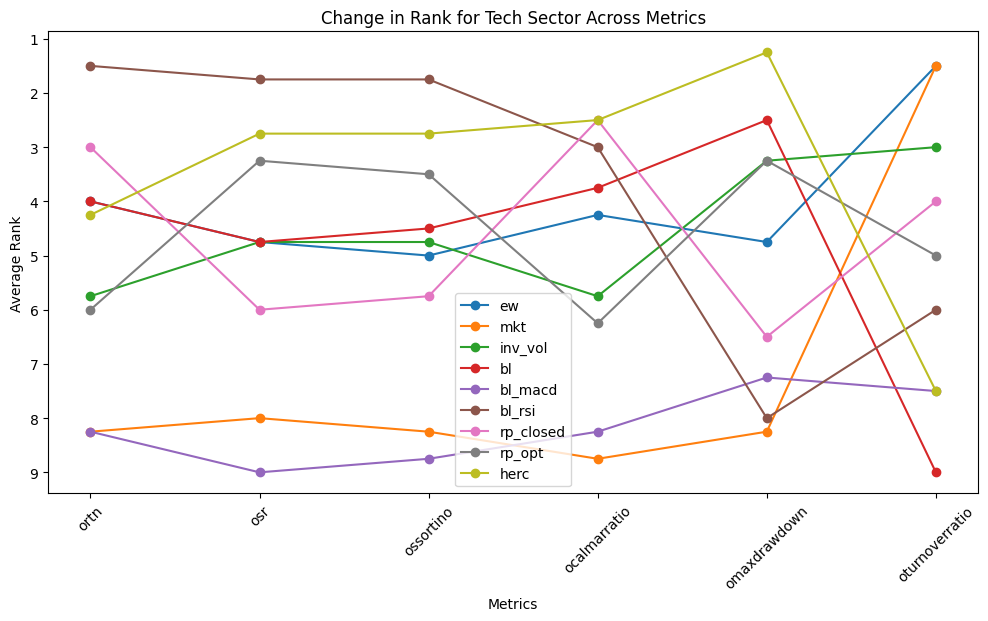

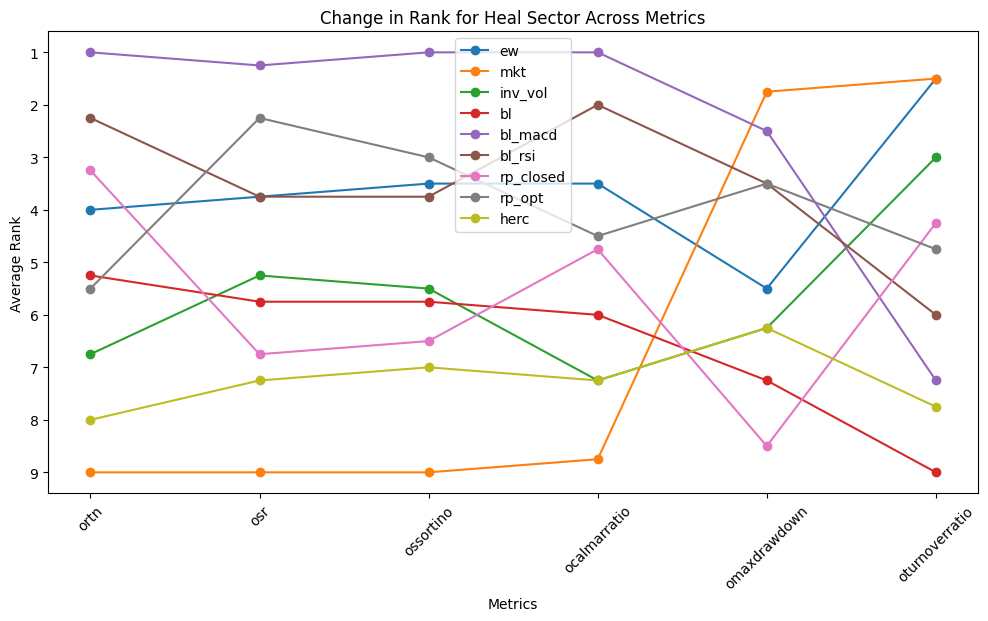

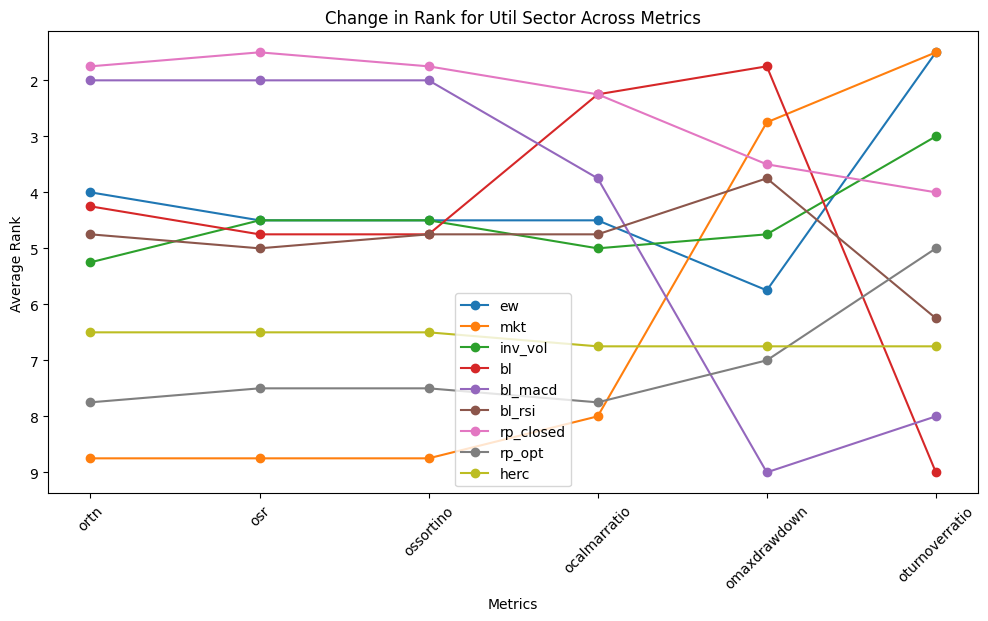

In [ ]:
sectors = ['tech', 'heal', 'util']
metrics = ['ortn', 'osr', 'ossortino', 'ocalmarratio', 'omaxdrawdown', 'oturnoverratio']
dataframes = [perf_tech_21, perf_heal_21, perf_util_21,
              perf_tech_63, perf_heal_63, perf_util_63,
              perf_tech_126, perf_heal_126, perf_util_126,
              perf_tech_252, perf_heal_252, perf_util_252]
copy_dataframes = [df.copy() for df in dataframes]
for df in copy_dataframes:
    df['method'] = df['method'].replace({
        'inverse_volatility_allocation': 'inv_vol',
        'black_litterman': 'bl',
        'black_litterman_macd': 'bl_macd',
        'black_litterman_rsi': 'bl_rsi',
        'risk_parity_optimization': 'rp_opt'
    })
titles = ['Tech 21', 'Health 21', 'Utilities 21',
          'Tech 63', 'Health 63', 'Utilities 63',
          'Tech 126', 'Health 126', 'Utilities 126',
          'Tech 252', 'Health 252', 'Utilities 252']

for sector in sectors:
    sector_dfs = [df for df, title in zip(copy_dataframes, titles) if sector.lower() in title.lower()]
    visualize_rank_changes(sector_dfs, sector, metrics)


In [ ]:
def bar_chart_ortn_multiple_dfs(dfs, titles):
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 15), sharey=True)
    axes = axes.ravel()

    for i, (title, df) in enumerate(zip(titles, dfs)):
        sns.barplot(ax=axes[i], x='method', y='ortn', data=df)
        axes[i].set_title(title)
        axes[i].set_ylabel("Ortn")
        axes[i].set_xlabel("Method")
        axes[i].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


In [ ]:
def line_graph_osr_multiple_dfs(dfs, titles):
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 15), sharey=True)
    axes = axes.ravel()

    for i, (title, df) in enumerate(zip(titles, dfs)):
        sns.lineplot(ax=axes[i], x='method', y='osr', data=df, marker='o')
        axes[i].set_title(title)
        axes[i].set_ylabel("OsR")
        axes[i].set_xlabel("Method")
        axes[i].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


In [ ]:
def scatter_osr_oturnoverratio_multiple_dfs(dfs, titles):
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 15), sharey=True)
    axes = axes.ravel()

    for i, (title, df) in enumerate(zip(titles, dfs)):
        sns.scatterplot(ax=axes[i], x='osr', y='oturnoverratio', hue='method', data=df)
        axes[i].set_title(title)
        axes[i].set_xlabel("OsR")
        axes[i].set_ylabel("Turnover Ratio")
        axes[i].legend(title='Method', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    plt.tight_layout()
    plt.show()

In [ ]:
def scatter_osr_ortn_multiple_dfs(dfs, titles):
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 15), sharey=True)
    axes = axes.ravel()

    for i, (title, df) in enumerate(zip(titles, dfs)):
        sns.scatterplot(ax=axes[i], x='osr', y='ortn', hue='method', data=df)
        axes[i].set_title(title)
        axes[i].set_xlabel("OsR")
        axes[i].set_ylabel("Ortn")
        axes[i].legend(title='Method', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    plt.tight_layout()
    plt.show()


In [ ]:
def scatter_osr_maxdrawdown_multiple_dfs(dfs, titles):
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 15), sharey=True)
    axes = axes.ravel()

    for i, (title, df) in enumerate(zip(titles, dfs)):
        sns.scatterplot(ax=axes[i], x='osr', y='omaxdrawdown', hue='method', data=df)
        axes[i].set_title(title)
        axes[i].set_xlabel("OsR")
        axes[i].set_ylabel("Max Drawdown")
        axes[i].legend(title='Method', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    plt.tight_layout()
    plt.show()


In [ ]:
def scatter_osr_ocalmarratio_multiple_dfs(dfs, titles):
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 15), sharey=True)
    axes = axes.ravel()

    for i, (title, df) in enumerate(zip(titles, dfs)):
        sns.scatterplot(ax=axes[i], x='osr', y='ocalmarratio', hue='method', data=df)
        axes[i].set_title(title)
        axes[i].set_xlabel("OsR")
        axes[i].set_ylabel("Calm Ratio")
        axes[i].legend(title='Method', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    plt.tight_layout()
    plt.show()

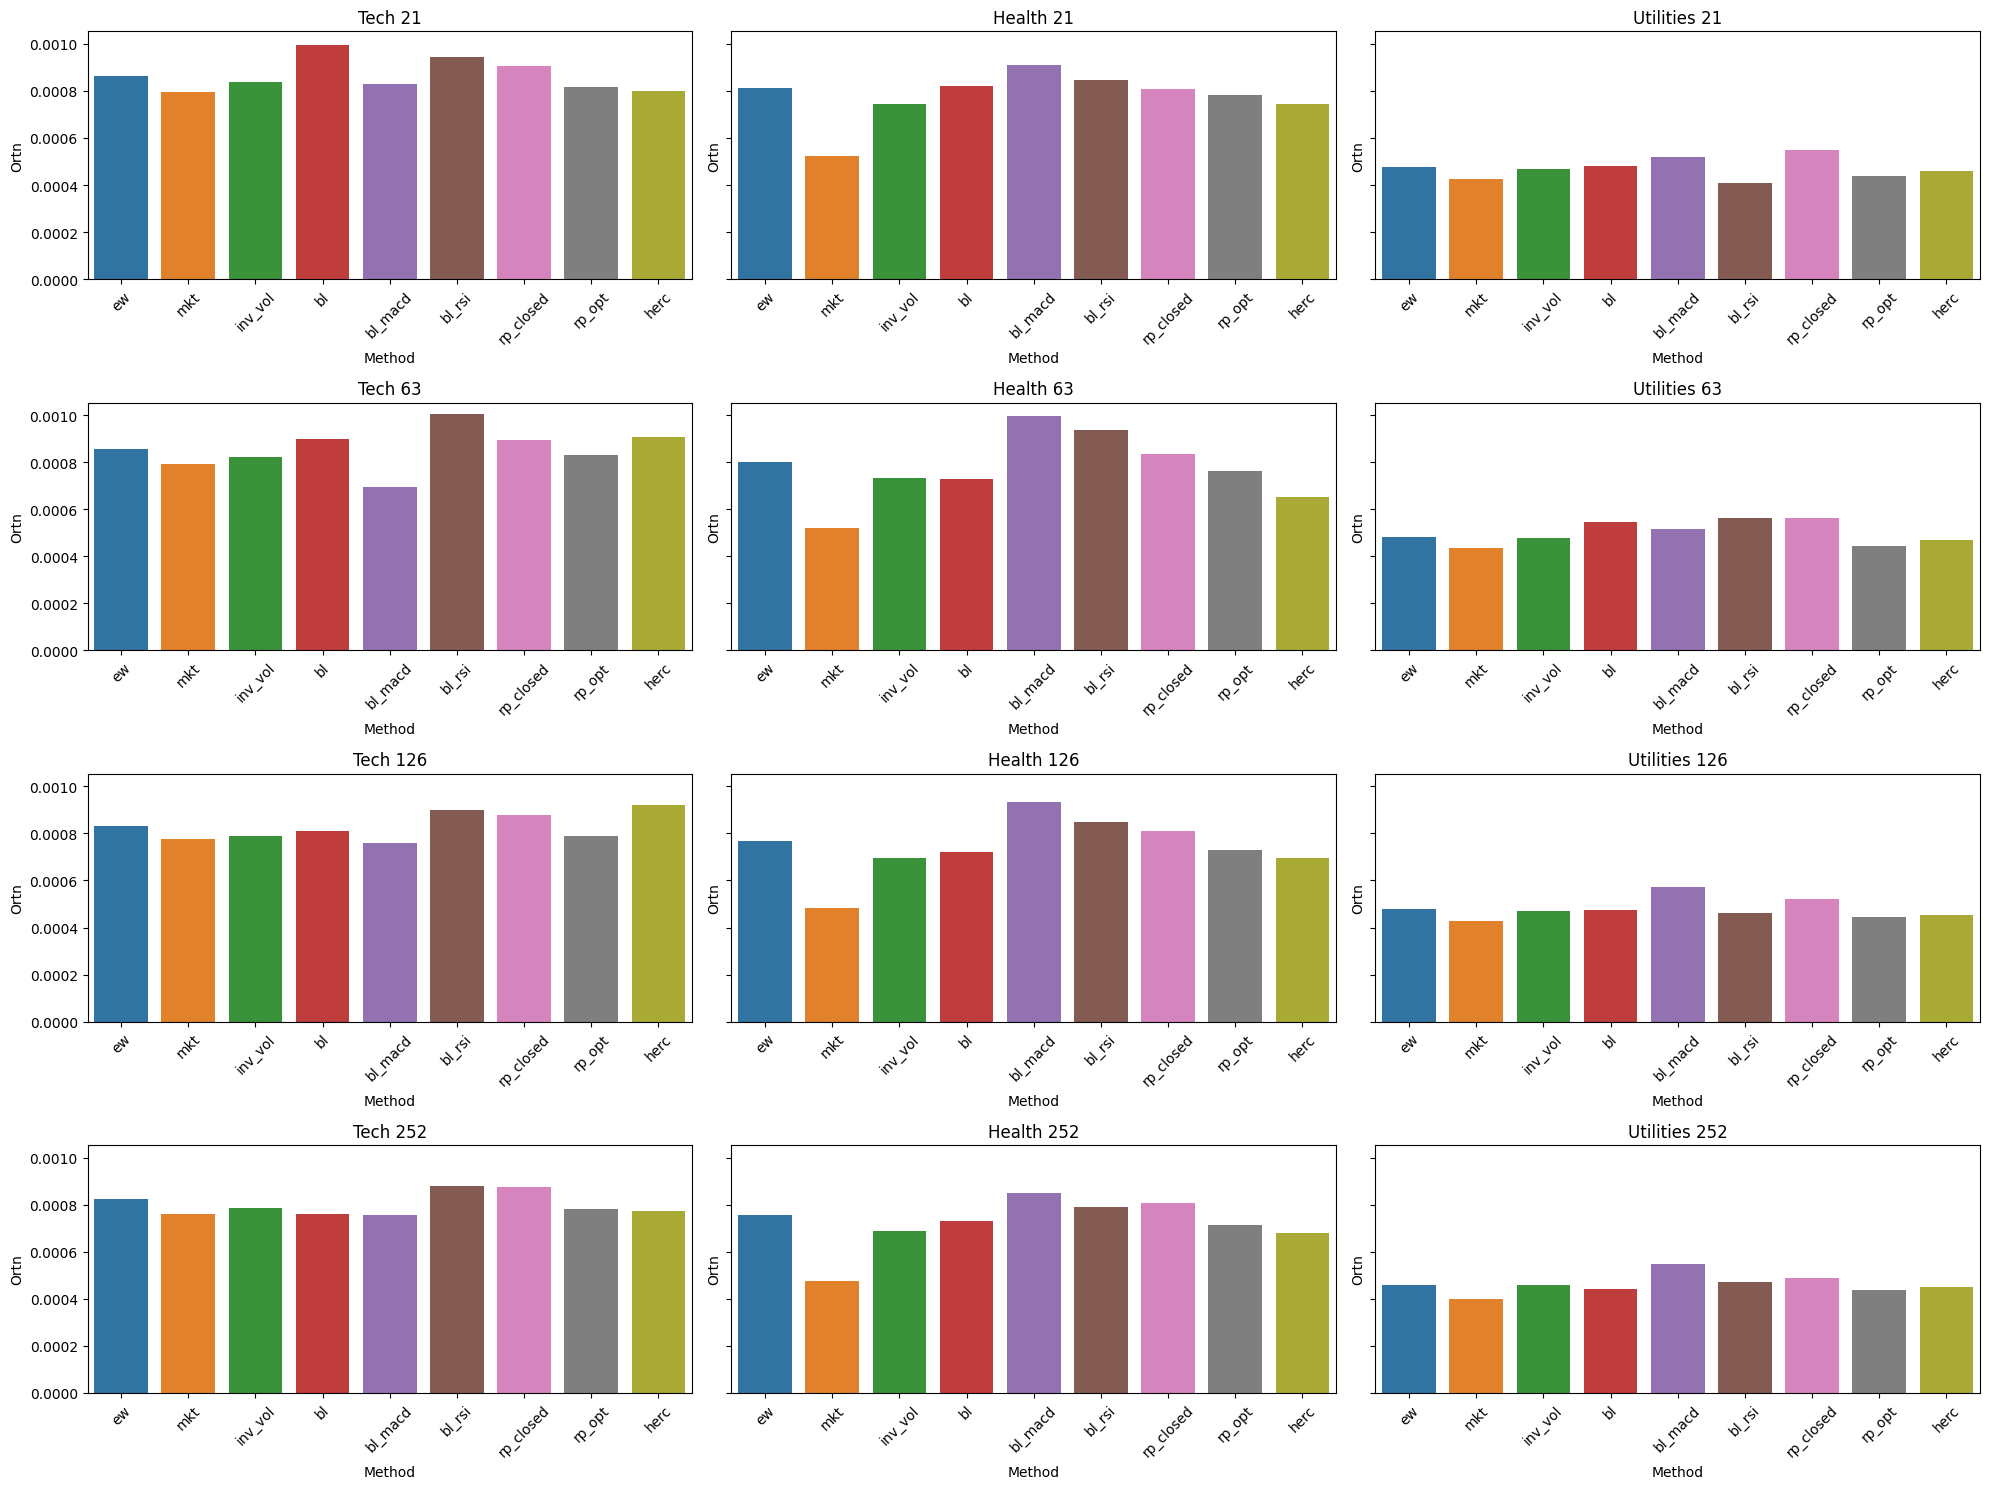

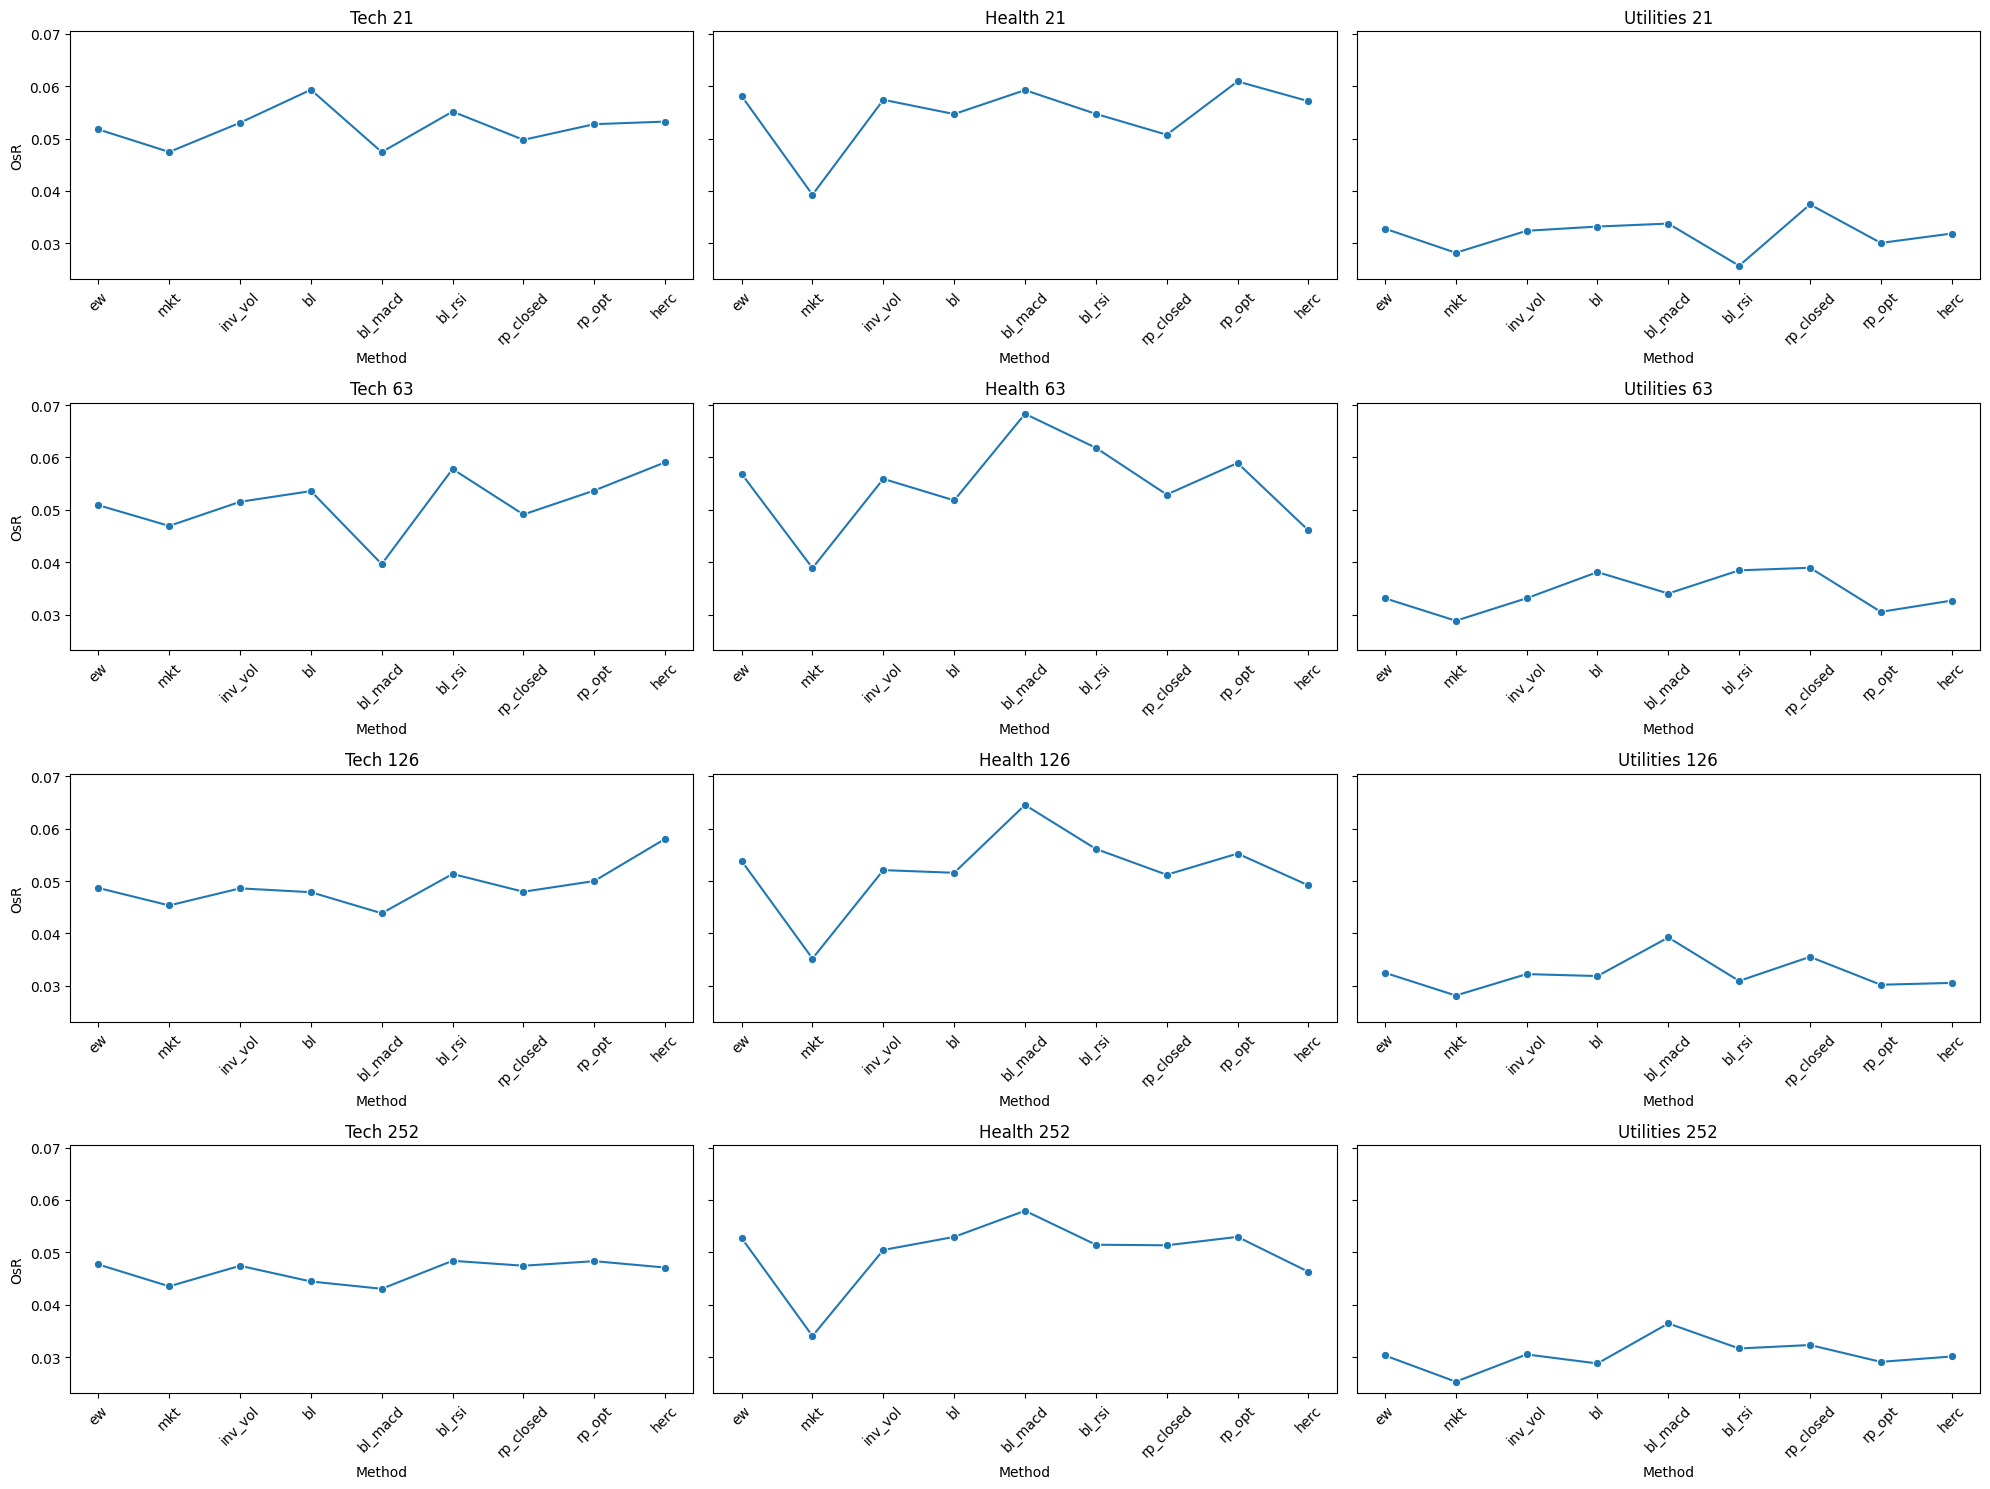

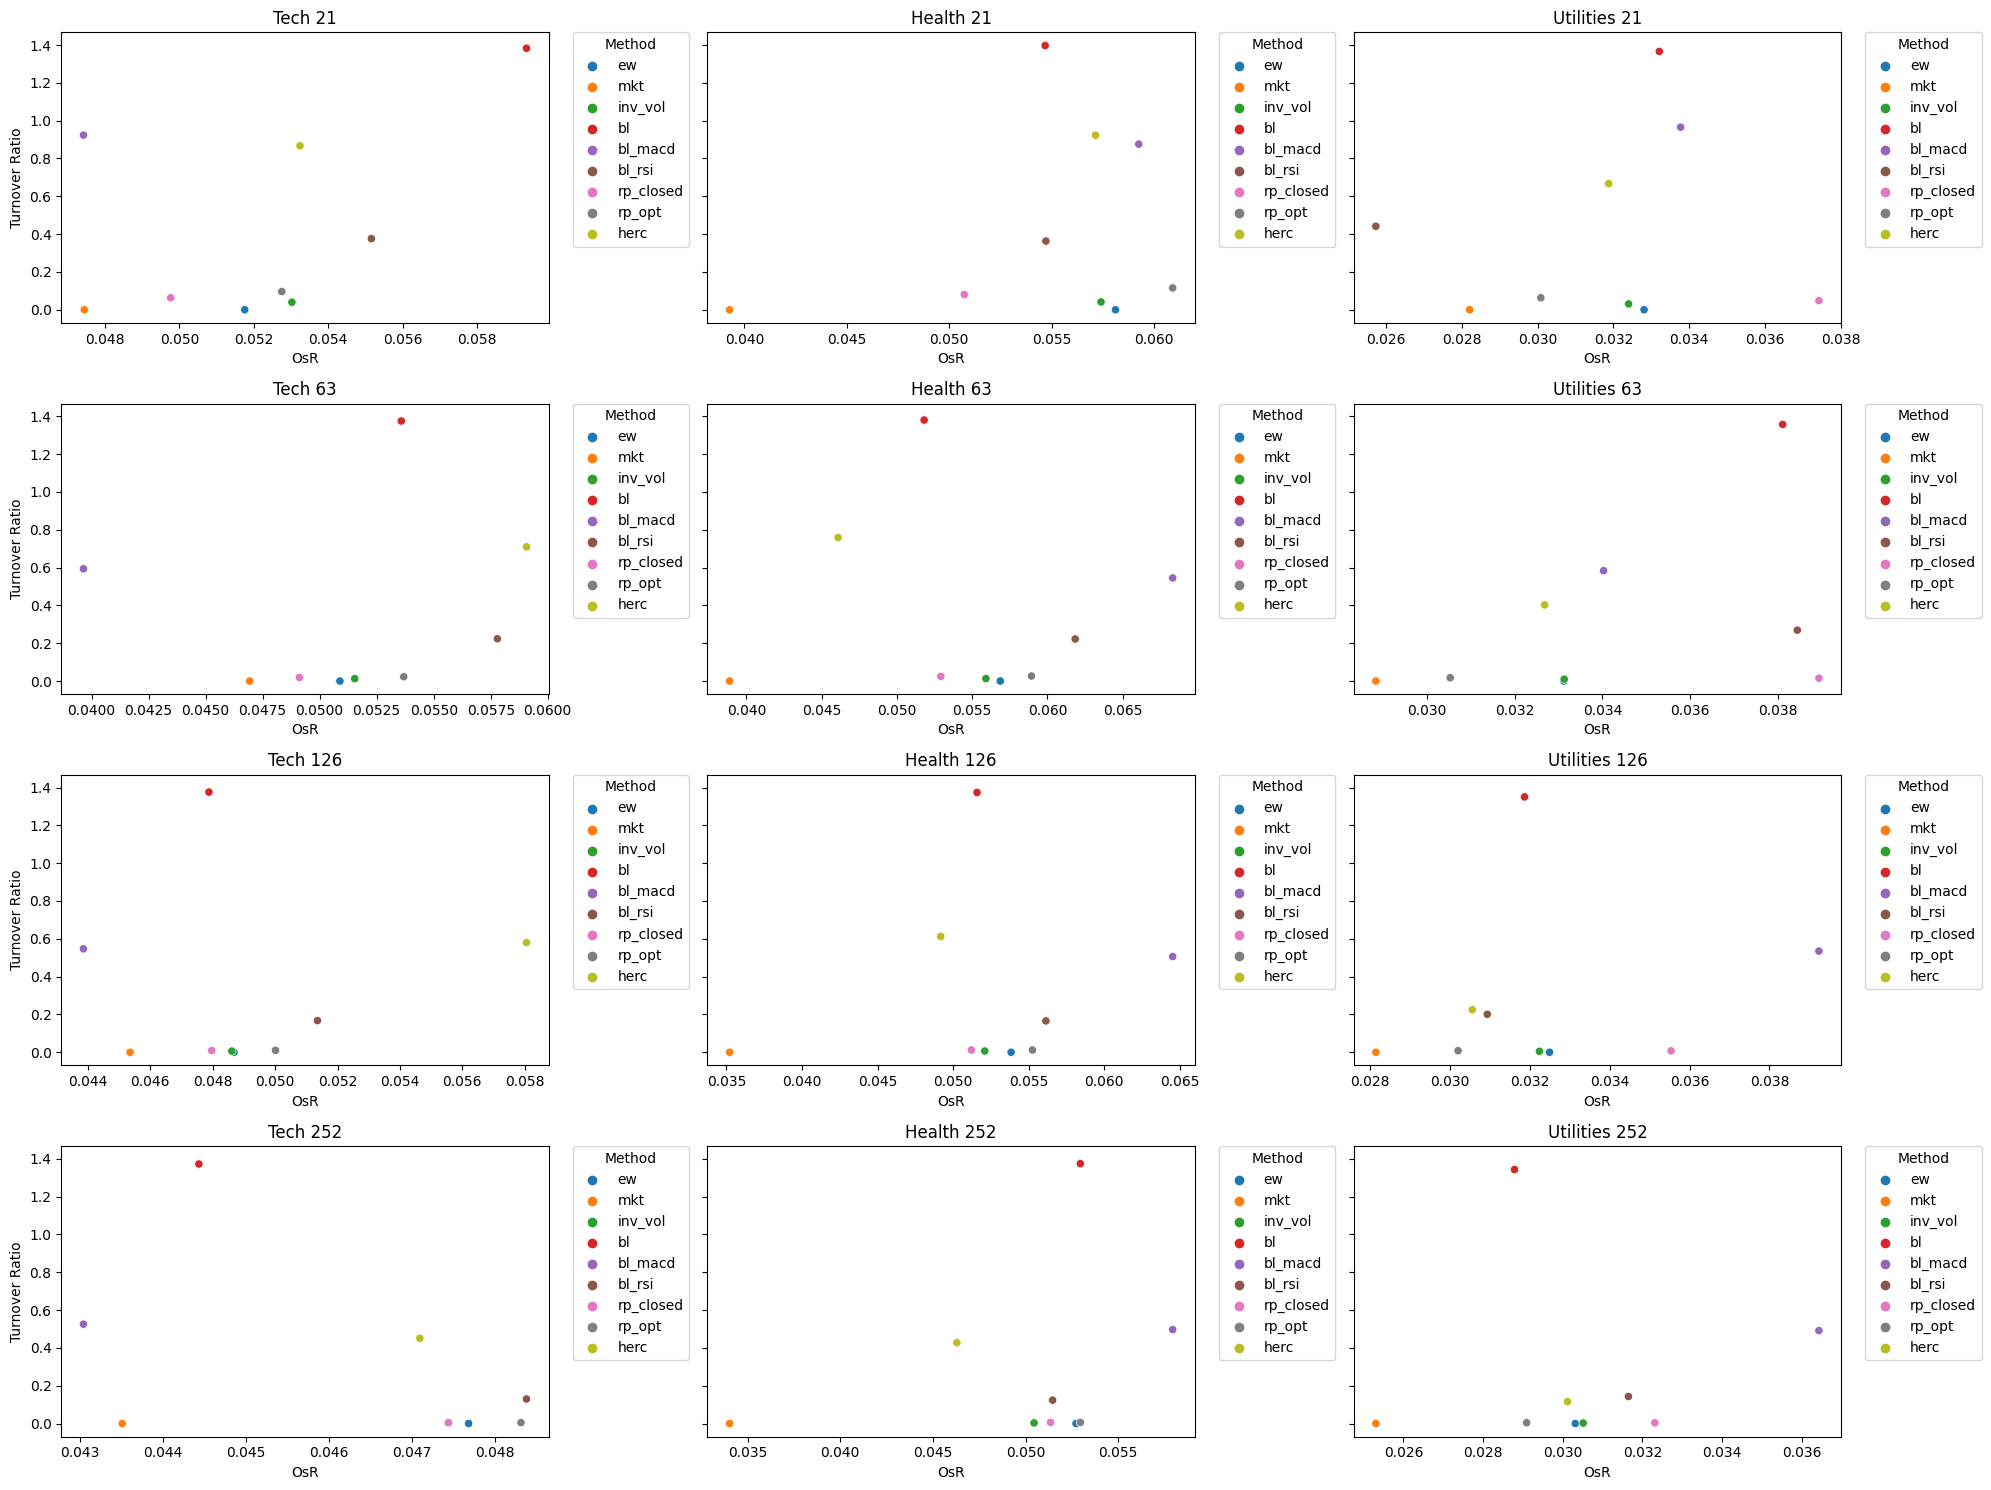

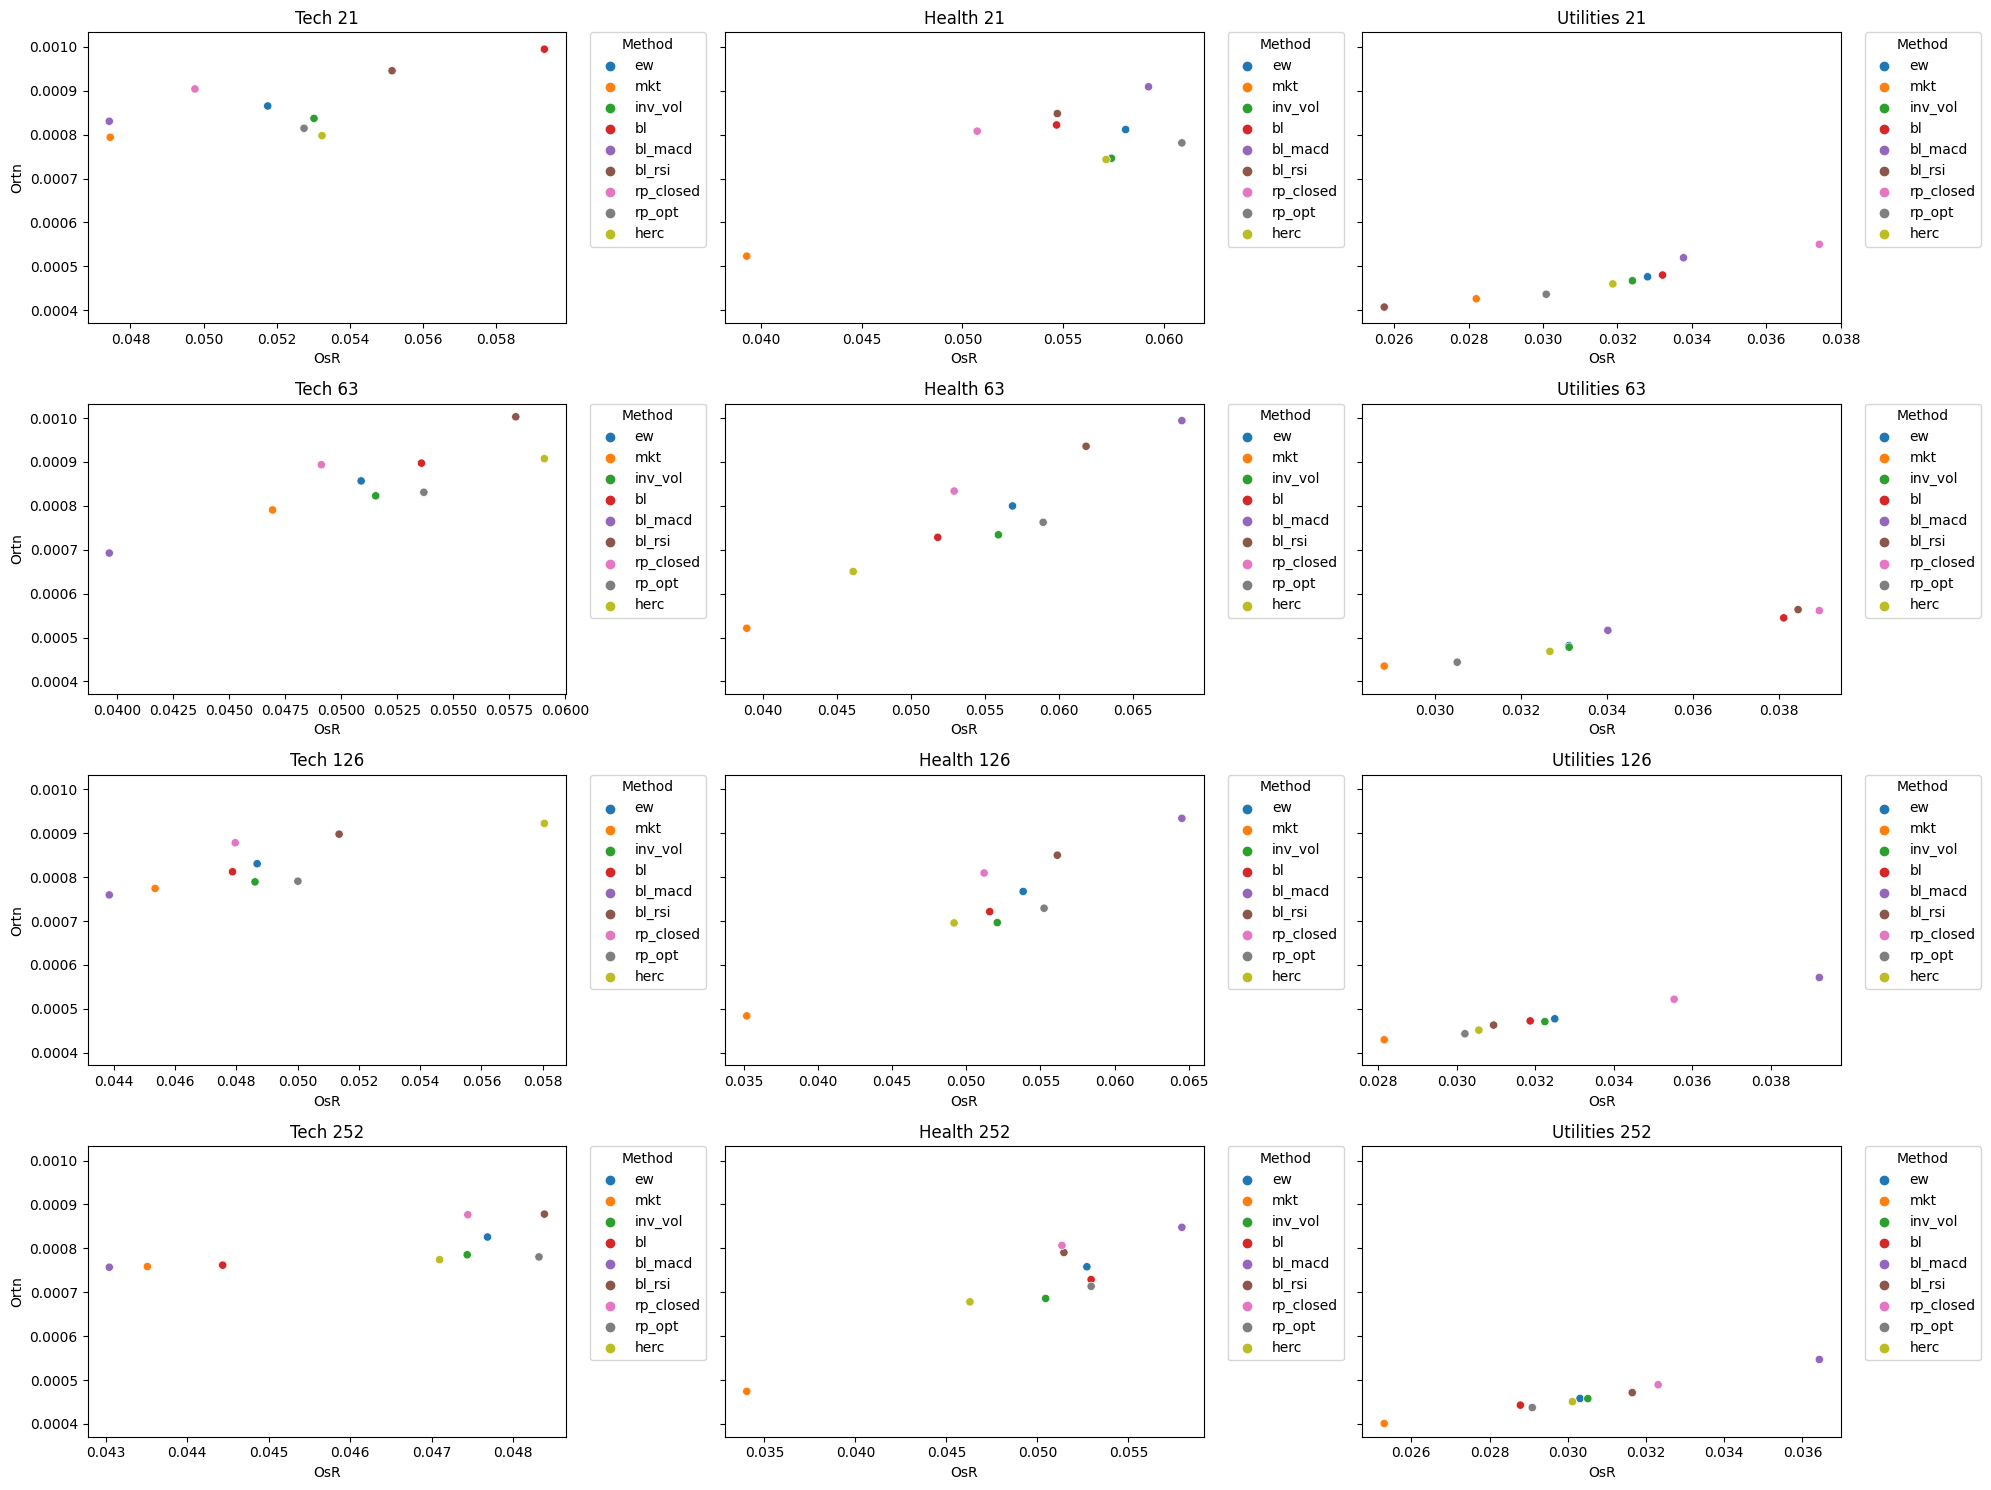

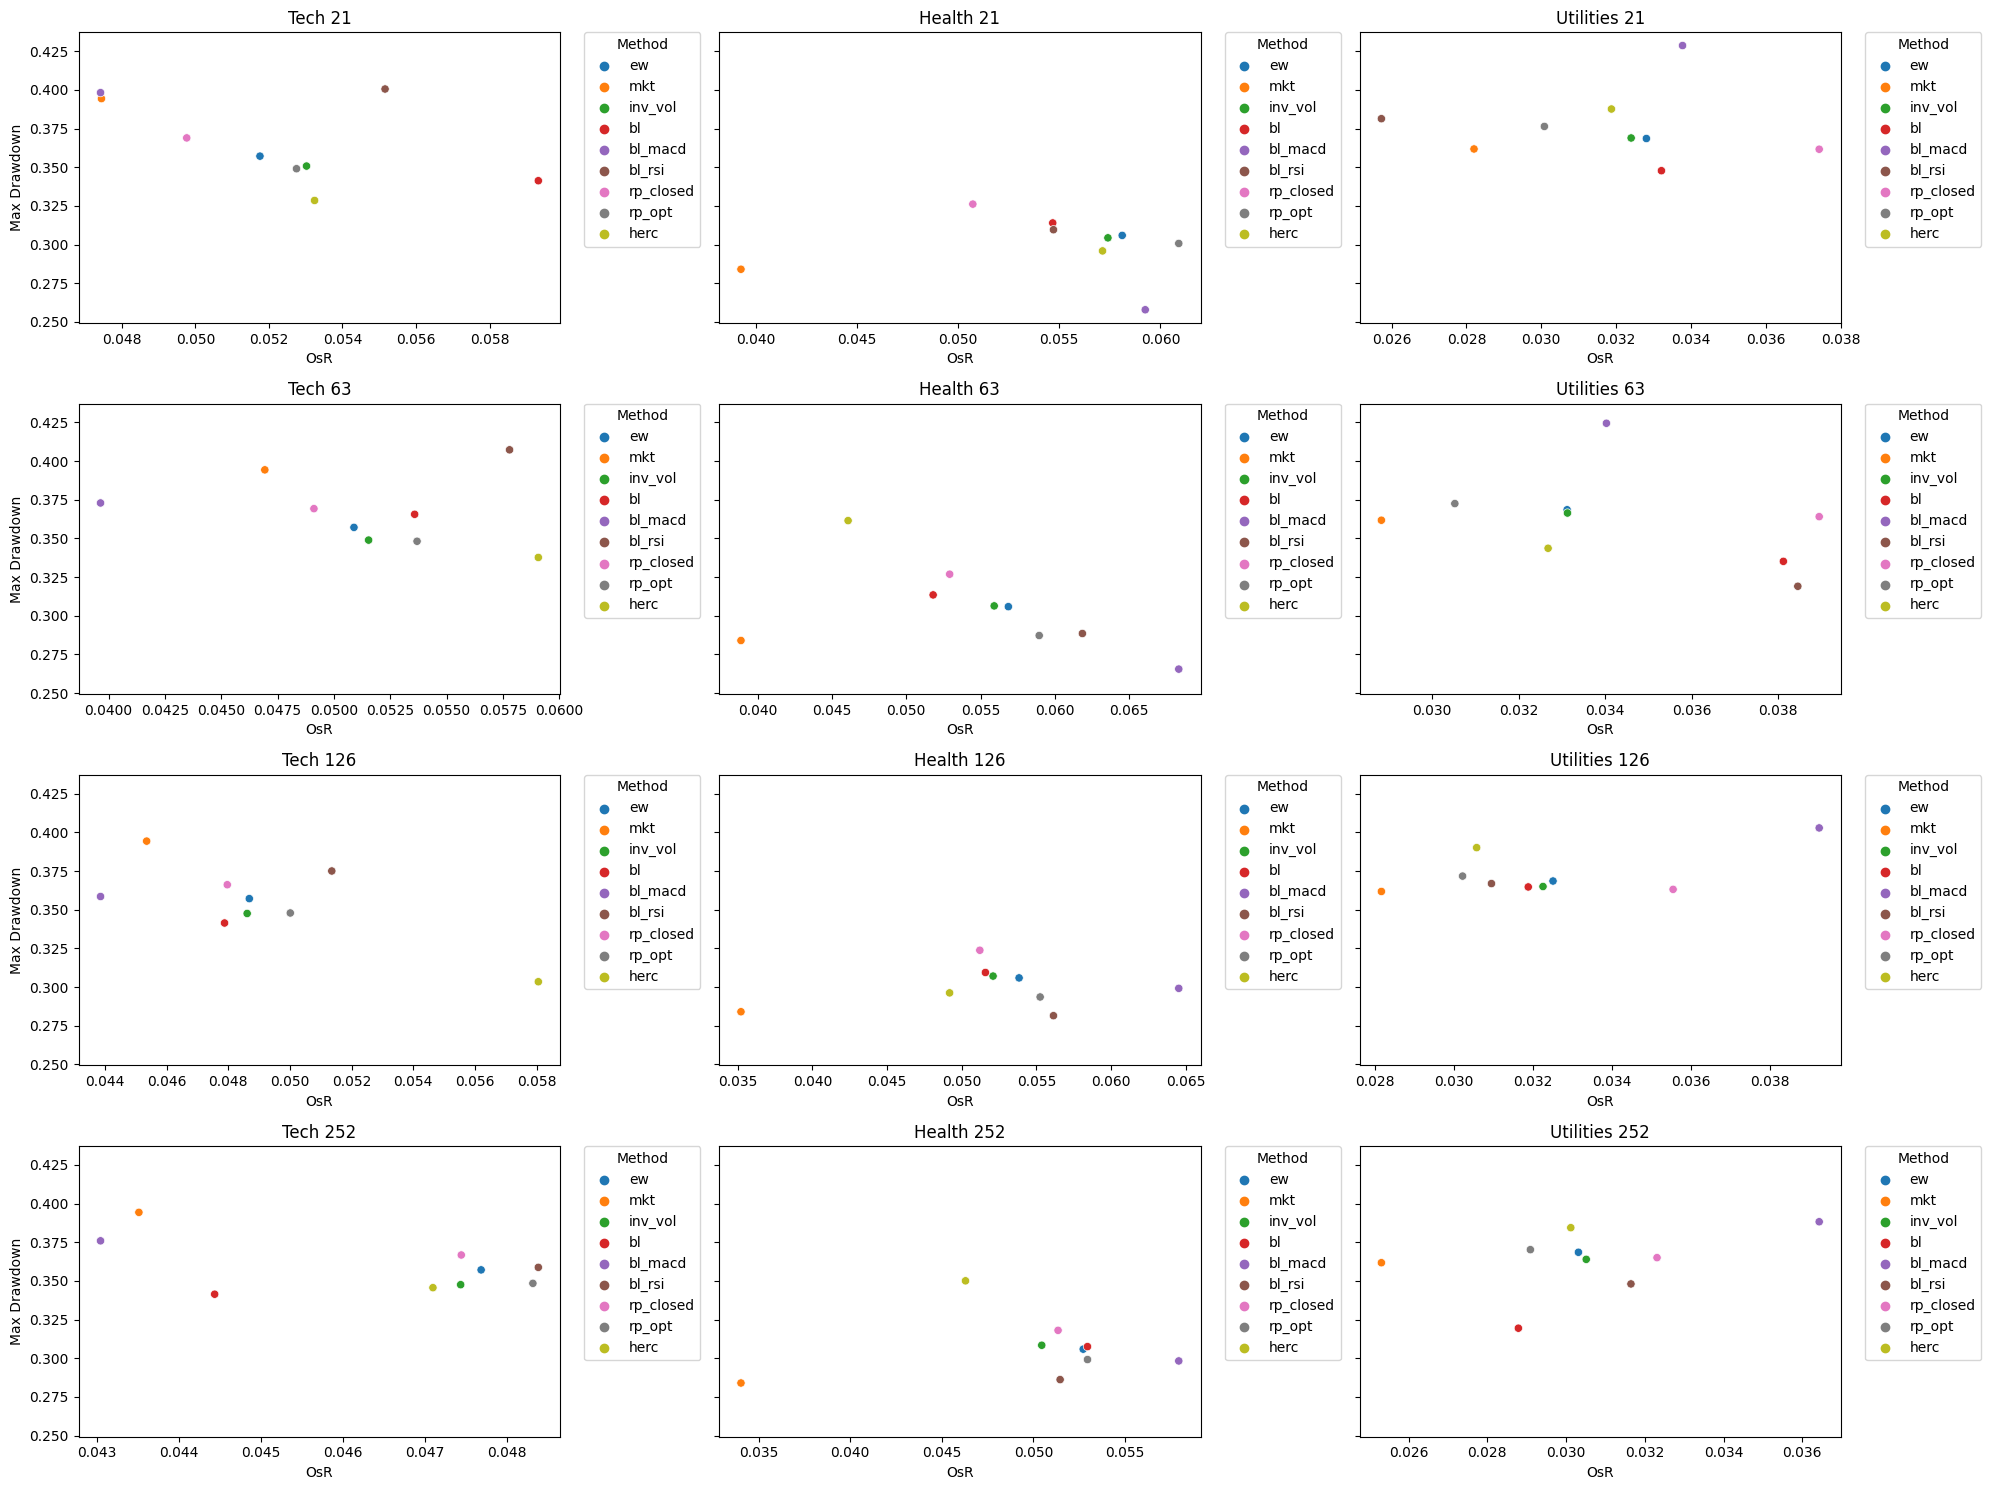

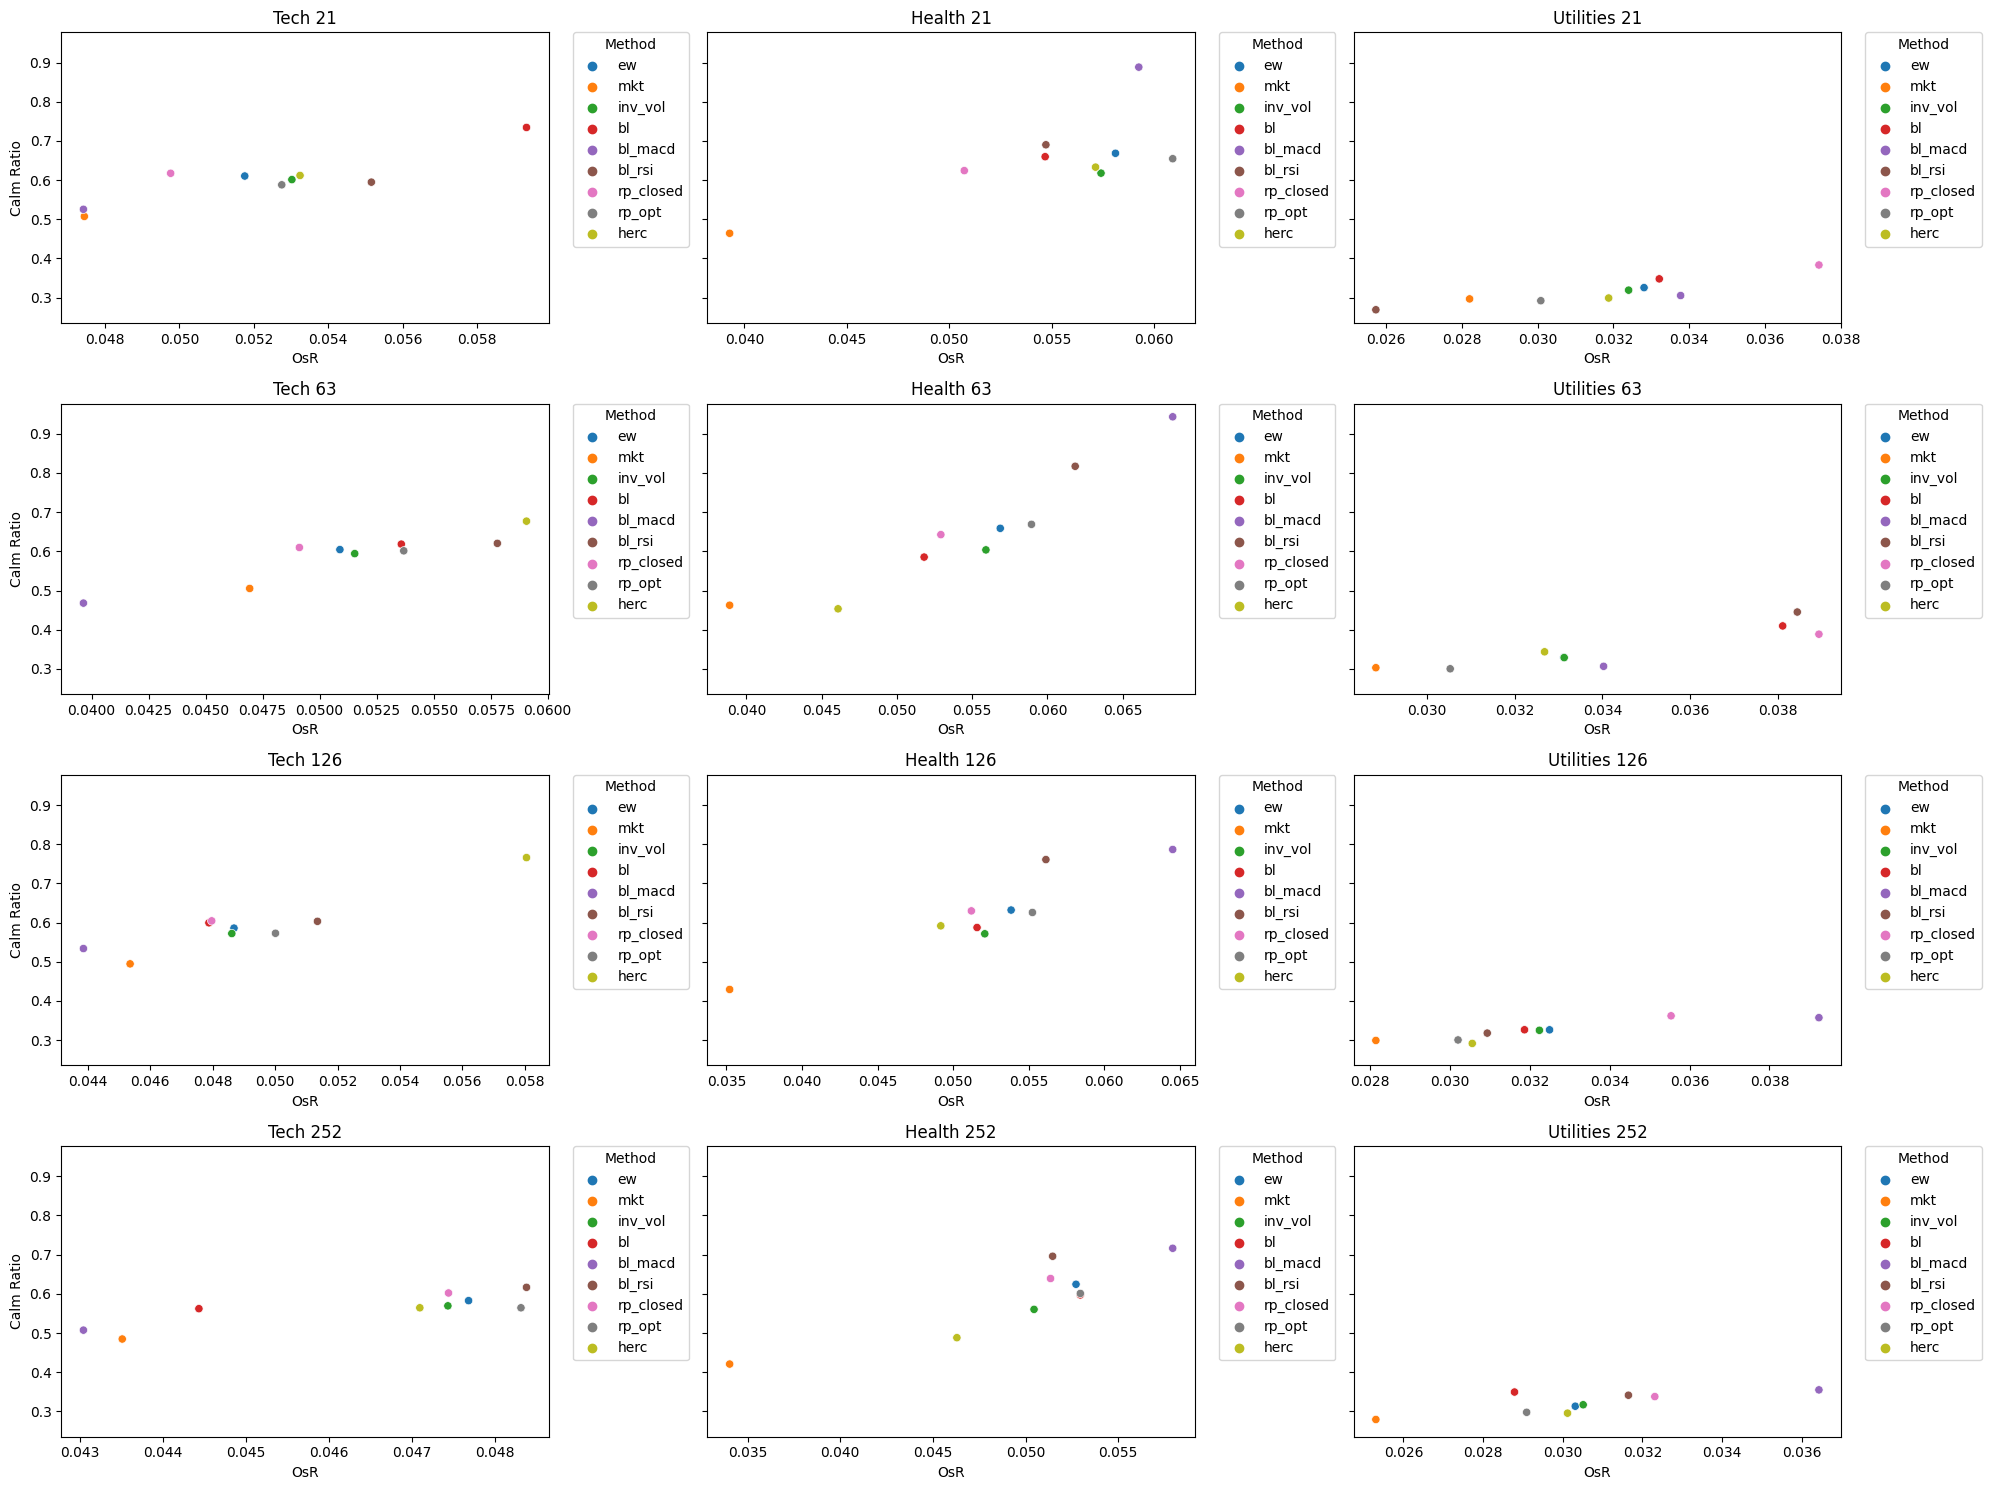

In [ ]:
bar_chart_ortn_multiple_dfs(copy_dataframes, titles)
line_graph_osr_multiple_dfs(copy_dataframes, titles)
scatter_osr_oturnoverratio_multiple_dfs(copy_dataframes, titles)
scatter_osr_ortn_multiple_dfs(copy_dataframes, titles)
scatter_osr_maxdrawdown_multiple_dfs(copy_dataframes, titles)
scatter_osr_ocalmarratio_multiple_dfs(copy_dataframes, titles)

## 1.7 Cumulative Return

In [ ]:
def OReturn(w, d, R, M, rf):
    e = np.ones((d, 1))
    X_t = rf + (R[:, M:] - rf * e).T @ w
    Return = np.diag(X_t)
    return Return

def getCumReturns(M, R, kappa, rf):
#     methods_name = ['ew', 'mkt', 'black_litterman_macd', 'black_litterman_rsi', 'rp_closed']
    methods_name = ['ew', 'mkt','rp_closed']
    d, T = R.shape

    para = [kappa, T, rf]
    method_returns = {}

    for method in methods_name:
        w = np.zeros((d, T - M))
        for i in range(0, T - M):
            R_M = R[:, i:i+M]
            w_t = get_weights(d, M, R_M, method, para)
            w[:,[i]] = w_t
        
        method_returns[method] = OReturn(w, d, R, M, rf)

    # Transpose the arrays in method_returns and create a DataFrame
    transposed_returns = {method: returns.T for method, returns in method_returns.items()}
    df_method_returns = pd.DataFrame(transposed_returns)

    # Calculate and add the cumulative return columns
    for method in methods_name:
        cumulative_returns_col = f"{method}_cumulative"
        df_method_returns[cumulative_returns_col] = (1 + df_method_returns[method]).cumprod() - 1
    
    display(df_method_returns)
    return df_method_returns


### M=21

In [ ]:
M = 21
kappa = 0.3/252
rf = 0.002/21
cumReturn_tech_21 = getCumReturns(M, Tech_Returns, kappa, rf)
cumReturn_heal_21 = getCumReturns(M, Healthcare_Returns, kappa, rf)
cumReturn_util_21 = getCumReturns(M, Utilities_Returns, kappa, rf)

,ew,mkt,rp_closed,ew_cumulative,mkt_cumulative,rp_closed_cumulative
0,-0.002317,-0.001492,-0.002345,-0.002317,-0.001492,-0.002345
1,0.006634,0.006655,0.005916,0.004302,0.005154,0.003557
2,-0.003691,0.000539,-0.003463,0.000595,0.005696,0.000081
3,0.006295,0.005528,0.006272,0.006894,0.011255,0.006354
4,0.013953,0.007108,0.014048,0.020944,0.018443,0.020492
...,...,...,...,...,...,...
2470,-0.003189,-0.003499,-0.003291,5.581860,4.378243,5.911971
2471,-0.004325,-0.003950,-0.004464,5.553394,4.356999,5.881119
2472,-0.027369,-0.023133,-0.031202,5.374036,4.233077,5.666412
2473,0.003717,0.014434,0.006504,5.397727,4.308610,5.709769


,ew,mkt,rp_closed,ew_cumulative,mkt_cumulative,rp_closed_cumulative
0,-0.004292,-0.006742,-0.004673,-0.004292,-0.006742,-0.004673
1,0.012559,0.005390,0.013629,0.008213,-0.001388,0.008892
2,-0.002907,-0.001886,-0.002580,0.005282,-0.003272,0.006289
3,-0.002026,-0.002288,-0.002439,0.003245,-0.005552,0.003835
4,0.017292,0.013857,0.017799,0.020593,0.008228,0.021703
...,...,...,...,...,...,...
2470,0.010644,0.007180,0.013119,5.286217,2.203004,4.933747
2471,0.002833,0.004870,-0.000430,5.304027,2.218603,4.931194
2472,-0.017544,-0.011801,-0.021262,5.193428,2.180621,4.805083
2473,-0.008526,-0.014074,-0.006960,5.140624,2.135857,4.764679


,ew,mkt,rp_closed,ew_cumulative,mkt_cumulative,rp_closed_cumulative
0,0.002895,0.003821,0.002698,0.002895,0.003821,0.002698
1,-0.011170,-0.012582,-0.011562,-0.008308,-0.008809,-0.008896
2,-0.000447,-0.000428,-0.000207,-0.008751,-0.009234,-0.009101
3,0.000380,-0.001179,0.000312,-0.008374,-0.010401,-0.008792
4,-0.000862,-0.002252,-0.001323,-0.009229,-0.012630,-0.010104
...,...,...,...,...,...,...
2470,0.002391,0.002102,0.002558,1.754388,1.440294,2.256578
2471,0.004563,0.004428,0.004534,1.766955,1.451100,2.271343
2472,0.000149,-0.000580,0.001144,1.767368,1.449678,2.275085
2473,-0.019023,-0.022638,-0.019878,1.714724,1.394224,2.209984


### M=63

In [ ]:
M = 63
kappa = 0.3/252
rf = 0.002/21
cumReturn_tech_63 = getCumReturns(M, Tech_Returns, kappa, rf)
cumReturn_heal_63 = getCumReturns(M, Healthcare_Returns, kappa, rf)
cumReturn_util_63 = getCumReturns(M, Utilities_Returns, kappa, rf)

,ew,mkt,rp_closed,ew_cumulative,mkt_cumulative,rp_closed_cumulative
0,0.006920,0.002737,0.008793,0.006920,0.002737,0.008793
1,0.009459,0.004809,0.010206,0.016444,0.007558,0.019088
2,-0.006521,-0.007114,-0.006630,0.009816,0.000391,0.012332
3,0.003547,0.003647,0.003359,0.013398,0.004040,0.015732
4,0.011275,0.010642,0.013283,0.024824,0.014725,0.029224
...,...,...,...,...,...,...
2428,-0.003189,-0.003499,-0.003382,5.227861,4.167992,5.507717
2429,-0.004325,-0.003950,-0.003993,5.200926,4.147578,5.481730
2430,-0.027369,-0.023133,-0.031438,5.031214,4.028500,5.277956
2431,0.003717,0.014434,0.006590,5.053632,4.101081,5.319328


,ew,mkt,rp_closed,ew_cumulative,mkt_cumulative,rp_closed_cumulative
0,0.003529,0.005024,0.004875,0.003529,0.005024,0.004875
1,0.005897,0.003749,0.007169,0.009447,0.008791,0.012079
2,-0.008779,-0.004788,-0.009369,0.000584,0.003961,0.002597
3,0.007587,0.005677,0.010669,0.008175,0.009661,0.013293
4,0.012577,0.012152,0.015229,0.020856,0.021930,0.028724
...,...,...,...,...,...,...
2428,0.010644,0.007180,0.012735,4.912364,2.121312,5.154301
2429,0.002833,0.004870,0.001386,4.929114,2.136514,5.162828
2430,-0.017544,-0.011801,-0.022835,4.825092,2.099501,5.022099
2431,-0.008526,-0.014074,-0.007241,4.775429,2.055879,4.978492


,ew,mkt,rp_closed,ew_cumulative,mkt_cumulative,rp_closed_cumulative
0,0.003543,0.003628,0.003650,0.003543,0.003628,0.003650
1,-0.005015,-0.004465,-0.004976,-0.001490,-0.000853,-0.001344
2,-0.003053,-0.002670,-0.002875,-0.004538,-0.003521,-0.004215
3,-0.012385,-0.011028,-0.012404,-0.016868,-0.014510,-0.016567
4,0.000441,0.000433,0.000256,-0.016434,-0.014083,-0.016316
...,...,...,...,...,...,...
2428,0.002391,0.002102,0.002599,1.739472,1.453052,2.299357
2429,0.004563,0.004428,0.004617,1.751972,1.463915,2.314591
2430,0.000149,-0.000580,0.000566,1.752382,1.462486,2.316466
2431,-0.019023,-0.022638,-0.019759,1.700024,1.406741,2.250938


### M=126

In [ ]:
M = 126
kappa = 0.3/252
rf = 0.002/21
cumReturn_tech_126 = getCumReturns(M, Tech_Returns, kappa, rf)
cumReturn_heal_126 = getCumReturns(M, Healthcare_Returns, kappa, rf)
cumReturn_util_126 = getCumReturns(M, Utilities_Returns, kappa, rf)

,ew,mkt,rp_closed,ew_cumulative,mkt_cumulative,rp_closed_cumulative
0,0.009636,0.004911,0.010088,0.009636,0.004911,0.010088
1,0.005369,0.010012,0.005122,0.015057,0.014972,0.015262
2,-0.001615,0.005429,-0.002371,0.013417,0.020482,0.012854
3,-0.004068,-0.004343,-0.003879,0.009295,0.016050,0.008926
4,-0.003057,0.003301,-0.002359,0.006210,0.019404,0.006546
...,...,...,...,...,...,...
2365,-0.003189,-0.003499,-0.003306,4.556288,3.735519,4.962426
2366,-0.004325,-0.003950,-0.004098,4.532257,3.716814,4.937994
2367,-0.027369,-0.023133,-0.031071,4.380846,3.607701,4.753494
2368,0.003717,0.014434,0.006796,4.400846,3.674208,4.792594


,ew,mkt,rp_closed,ew_cumulative,mkt_cumulative,rp_closed_cumulative
0,0.003462,-0.003009,0.004919,0.003462,-0.003009,0.004919
1,0.002602,0.000862,0.003396,0.006073,-0.002149,0.008331
2,0.001092,0.000086,0.002190,0.007172,-0.002063,0.010539
3,0.001584,0.000947,0.002150,0.008768,-0.001118,0.012712
4,-0.004935,-0.009207,-0.005917,0.003790,-0.010314,0.006720
...,...,...,...,...,...,...
2365,0.010644,0.007180,0.012444,4.216731,1.769318,4.549953
2366,0.002833,0.004870,0.001340,4.231510,1.782805,4.557387
2367,-0.017544,-0.011801,-0.023293,4.139728,1.749966,4.427941
2368,-0.008526,-0.014074,-0.007040,4.095908,1.711263,4.389729


,ew,mkt,rp_closed,ew_cumulative,mkt_cumulative,rp_closed_cumulative
0,-0.009905,-0.008282,-0.010413,-0.009905,-0.008282,-0.010413
1,-0.002552,-0.002818,-0.002514,-0.012432,-0.011076,-0.012900
2,-0.000337,-0.000524,-0.000382,-0.012765,-0.011594,-0.013277
3,-0.002291,-0.003875,-0.002290,-0.015026,-0.015425,-0.015536
4,0.002133,0.004521,0.002556,-0.012925,-0.010973,-0.013020
...,...,...,...,...,...,...
2365,0.002391,0.002102,0.002514,1.635003,1.360476,1.908541
2366,0.004563,0.004428,0.004563,1.647026,1.370929,1.921814
2367,0.000149,-0.000580,0.000273,1.647421,1.369554,1.922611
2368,-0.019023,-0.022638,-0.019517,1.597059,1.315913,1.865570


### M=252

In [ ]:
M = 252
kappa = 0.3/252
rf = 0.002/21
cumReturn_tech_252 = getCumReturns(M, Tech_Returns, kappa, rf)
cumReturn_heal_252 = getCumReturns(M, Healthcare_Returns, kappa, rf)
cumReturn_util_252 = getCumReturns(M, Utilities_Returns, kappa, rf)

,ew,mkt,rp_closed,ew_cumulative,mkt_cumulative,rp_closed_cumulative
0,-0.006884,-0.000742,-0.009679,-0.006884,-0.000742,-0.009679
1,-0.001851,-0.001273,-0.002722,-0.008721,-0.002015,-0.012375
2,0.001521,-0.000637,0.001285,-0.007214,-0.002651,-0.011106
3,0.003945,0.002871,0.004115,-0.003298,0.000212,-0.007036
4,0.012501,0.008799,0.014893,0.009161,0.009013,0.007752
...,...,...,...,...,...,...
2239,-0.003189,-0.003499,-0.003329,3.987254,3.167920,4.381194
2240,-0.004325,-0.003950,-0.004168,3.965685,3.151457,4.358766
2241,-0.027369,-0.023133,-0.030742,3.829780,3.055422,4.194025
2242,0.003717,0.014434,0.006281,3.847732,3.113957,4.226649


,ew,mkt,rp_closed,ew_cumulative,mkt_cumulative,rp_closed_cumulative
0,-0.004454,0.002480,-0.007215,-0.004454,0.002480,-0.007215
1,-0.002051,0.001277,-0.003099,-0.006496,0.003760,-0.010291
2,0.005279,0.002550,0.005256,-0.001251,0.006319,-0.005089
3,0.006597,0.002544,0.008363,0.005338,0.008879,0.003232
4,0.009050,0.003092,0.011817,0.014436,0.011999,0.015087
...,...,...,...,...,...,...
2239,0.010644,0.007180,0.012232,3.673288,1.563080,4.054334
2240,0.002833,0.004870,0.001168,3.686527,1.575563,4.060238
2241,-0.017544,-0.011801,-0.022300,3.604306,1.545170,3.947394
2242,-0.008526,-0.014074,-0.007298,3.565051,1.509349,3.911285


,ew,mkt,rp_closed,ew_cumulative,mkt_cumulative,rp_closed_cumulative
0,0.007298,0.008163,0.007378,0.007298,0.008163,0.007378
1,-0.000821,-0.000931,-0.000927,0.006472,0.007224,0.006444
2,0.002305,0.002236,0.002394,0.008792,0.009476,0.008854
3,0.000099,0.001487,-0.000072,0.008891,0.010977,0.008781
4,0.009173,0.008631,0.009443,0.018146,0.019703,0.018308
...,...,...,...,...,...,...
2239,0.002391,0.002102,0.002500,1.384010,1.104352,1.542642
2240,0.004563,0.004428,0.004571,1.394888,1.113671,1.554263
2241,0.000149,-0.000580,0.000197,1.395245,1.112445,1.554767
2242,-0.019023,-0.022638,-0.019462,1.349680,1.064625,1.505047


In [ ]:
def plot_cumulative_returns(dfs, titles, figsize=(16, 24)):
    num_dfs = len(dfs)

    fig, axes = plt.subplots(nrows=num_dfs, ncols=1, figsize=figsize)
    fig.tight_layout(pad=5.0)

    for i, (df, title) in enumerate(zip(dfs, titles)):
        ax = axes[i]

        # Plot the cumulative returns for each method
        ax.plot(df['ew_cumulative'], label='EW')
        ax.plot(df['mkt_cumulative'], label='MKT')
        ax.plot(df['rp_closed_cumulative'], label='RP_CLOSED')

        # Customize the chart
        ax.set_title(title)
        ax.set_xlabel('Time')
        ax.set_ylabel('Cumulative Return')
        ax.legend(loc='upper left')
        ax.grid(True)

    # Display the charts
    plt.show()

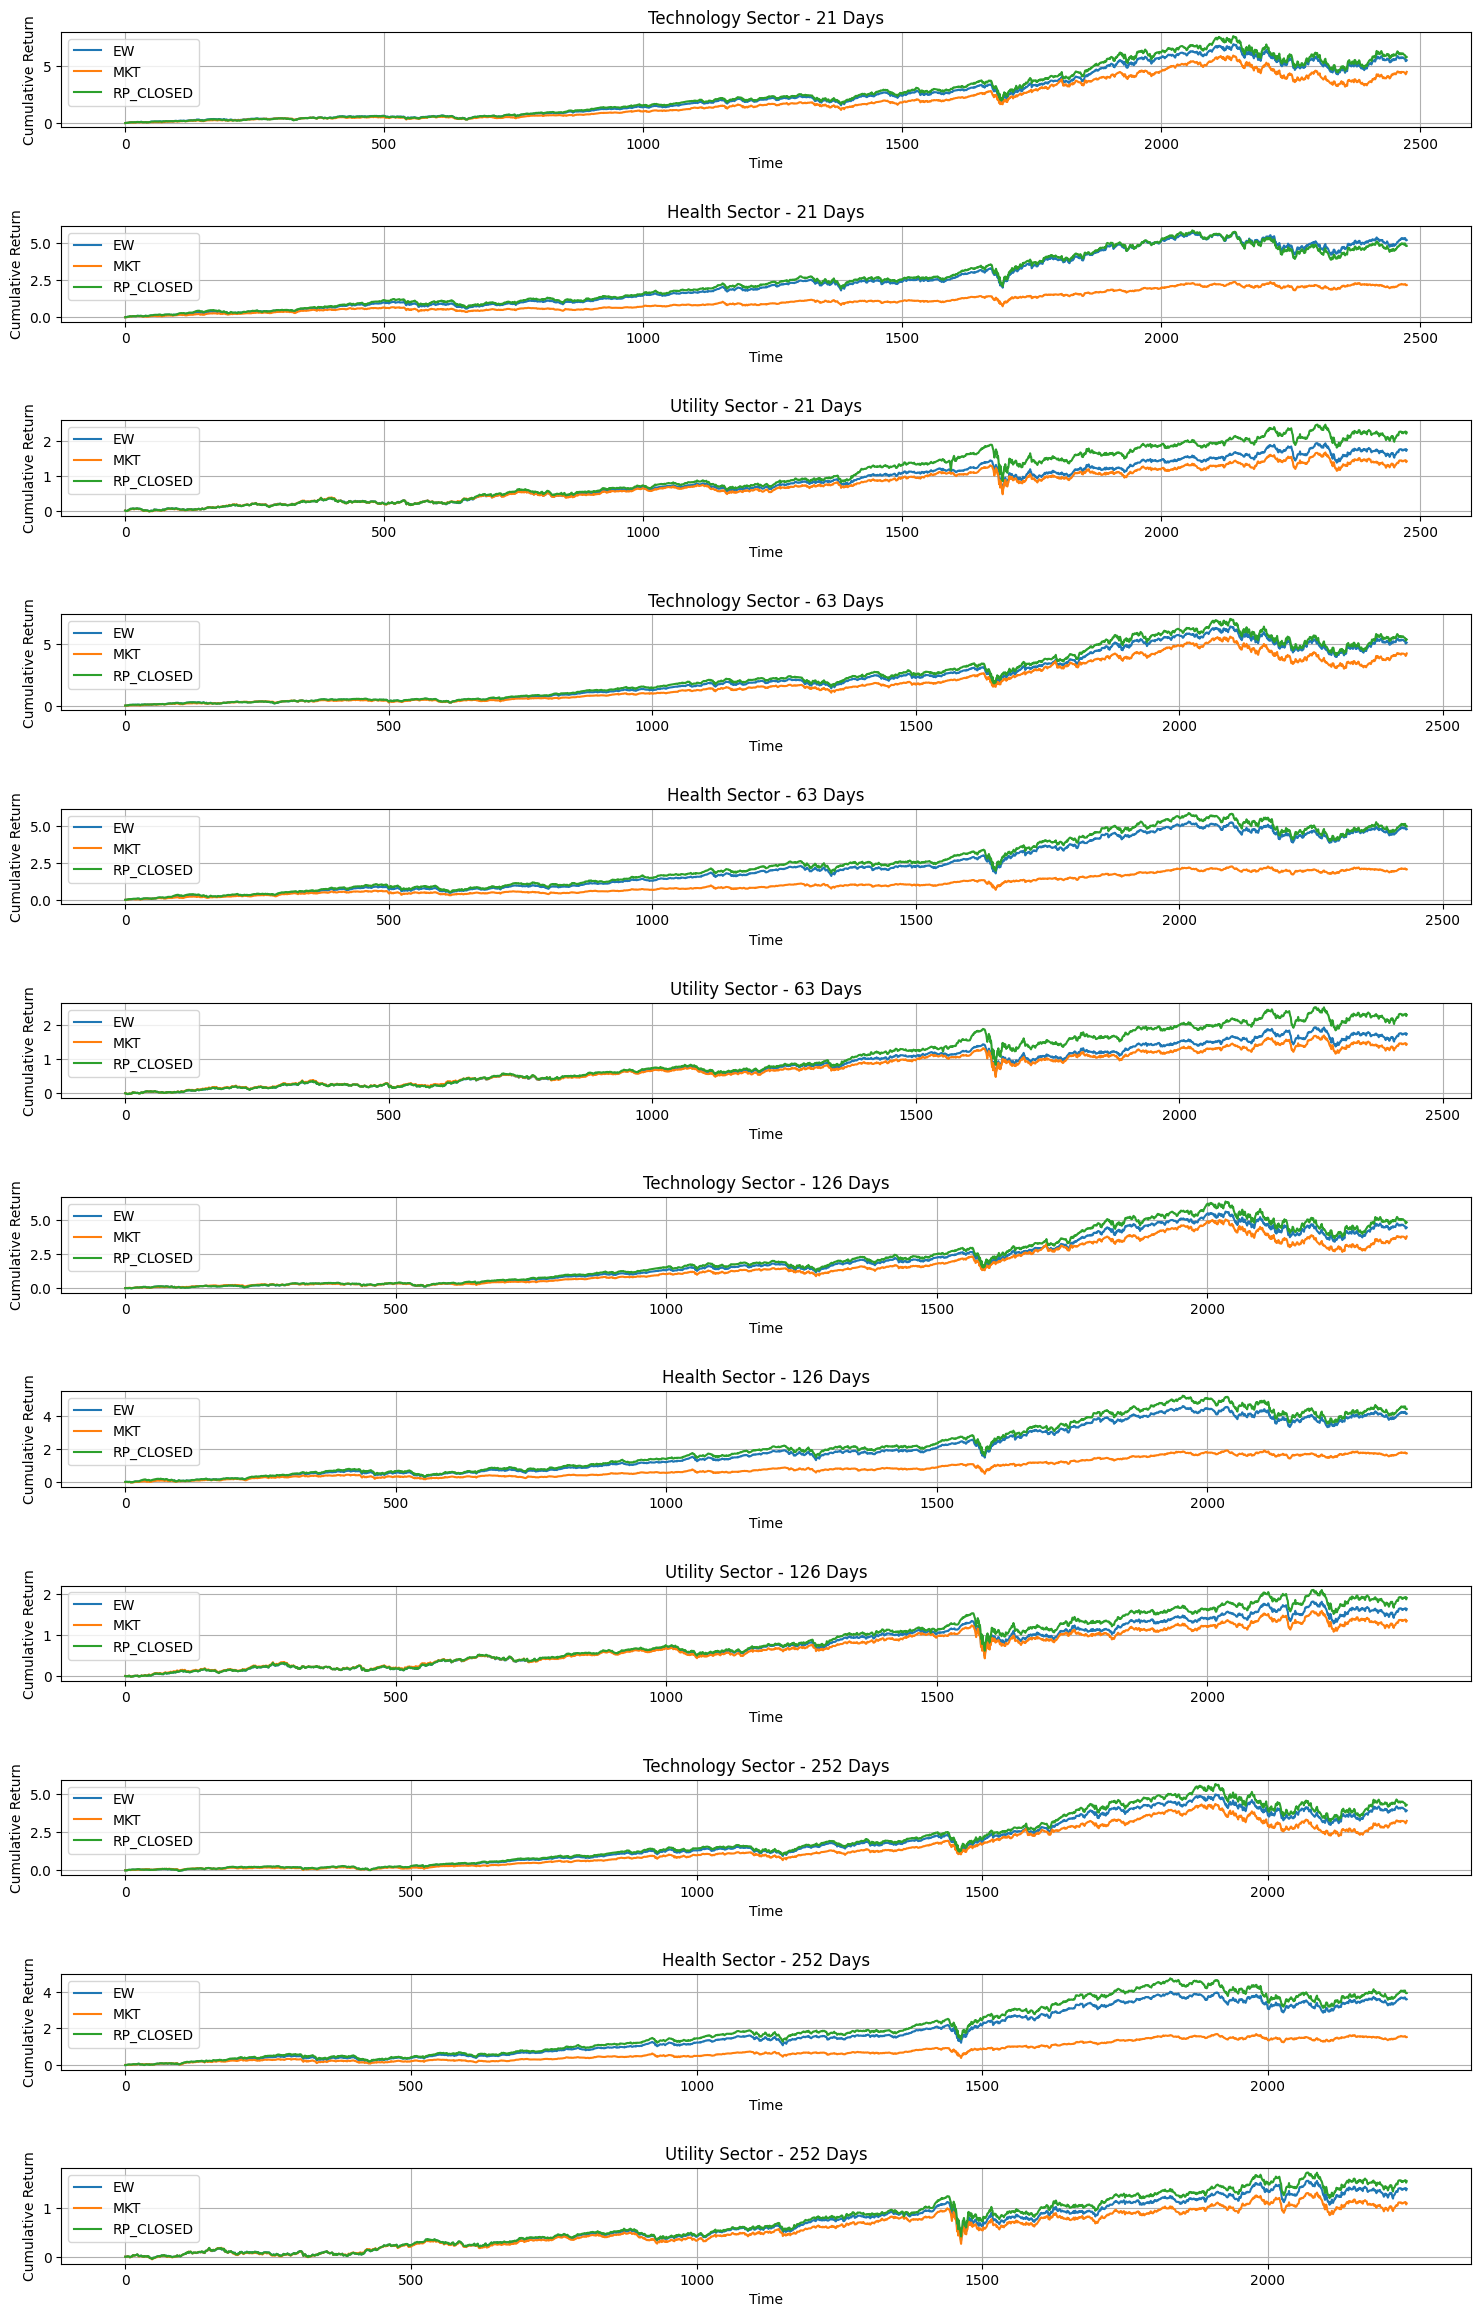

In [ ]:
dataframes = [
    cumReturn_tech_21, cumReturn_heal_21, cumReturn_util_21,
    cumReturn_tech_63, cumReturn_heal_63, cumReturn_util_63,
    cumReturn_tech_126, cumReturn_heal_126, cumReturn_util_126,
    cumReturn_tech_252, cumReturn_heal_252, cumReturn_util_252
]

titles = [
    'Technology Sector - 21 Days', 'Health Sector - 21 Days', 'Utility Sector - 21 Days',
    'Technology Sector - 63 Days', 'Health Sector - 63 Days', 'Utility Sector - 63 Days',
    'Technology Sector - 126 Days', 'Health Sector - 126 Days', 'Utility Sector - 126 Days',
    'Technology Sector - 252 Days', 'Health Sector - 252 Days', 'Utility Sector - 252 Days'
]

plot_cumulative_returns(dataframes, titles)

## 1.8 Turnover Ratio

In [ ]:
def daily_OTurnoverRatio(w, d, R, M, rf):
    e = np.ones((d, 1))
    X_t = rf + (R[:, M:] - rf * e).T @ w

    # Calculate the number of periods
    n_periods = X_t.shape[1]

    # Calculate the turnover for each day
    turnovers = np.sum(np.abs(w[:, 1:] - w[:, :-1]), axis=0)

    return turnovers

In [ ]:
def getTurnover(M, R, kappa, rf):
    methods_name = ['ew', 'mkt', 'black_litterman_macd', 'black_litterman_rsi', 'rp_closed']
    methods_name = ['ew', 'mkt', 'rp_closed']
    d, T = R.shape

    para = [kappa, T, rf]
    method_turnovers = {}

    for method in methods_name:
        w = np.zeros((d, T - M))
        for i in range(0, T - M):
            R_M = R[:, i:i+M]
            w_t = get_weights(d, M, R_M, method, para)
            w[:,[i]] = w_t
        
        method_turnovers[method] = daily_OTurnoverRatio(w, d, R, M, rf)

    # Transpose the arrays in method_turnovers and create a DataFrame
    transposed_turnovers = {method: turnovers.T for method, turnovers in method_turnovers.items()}
    df_method_turnovers = pd.DataFrame(transposed_turnovers)

    return df_method_turnovers


In [ ]:
M_values = [21, 63, 126, 252]
kappa = 0.3 / 252
rf = 0.002 / 21

# Store the DataFrames in a dictionary with keys as the DataFrame names
turnover_dfs = {}

for M in M_values:
    df_name_tech = f"turnover_tech_{M}"
    df_name_heal = f"turnover_heal_{M}"
    df_name_util = f"turnover_util_{M}"
    
    turnover_dfs[df_name_tech] = getTurnover(M, Tech_Returns, kappa, rf)
    turnover_dfs[df_name_heal] = getTurnover(M, Healthcare_Returns, kappa, rf)
    turnover_dfs[df_name_util] = getTurnover(M, Utilities_Returns, kappa, rf)


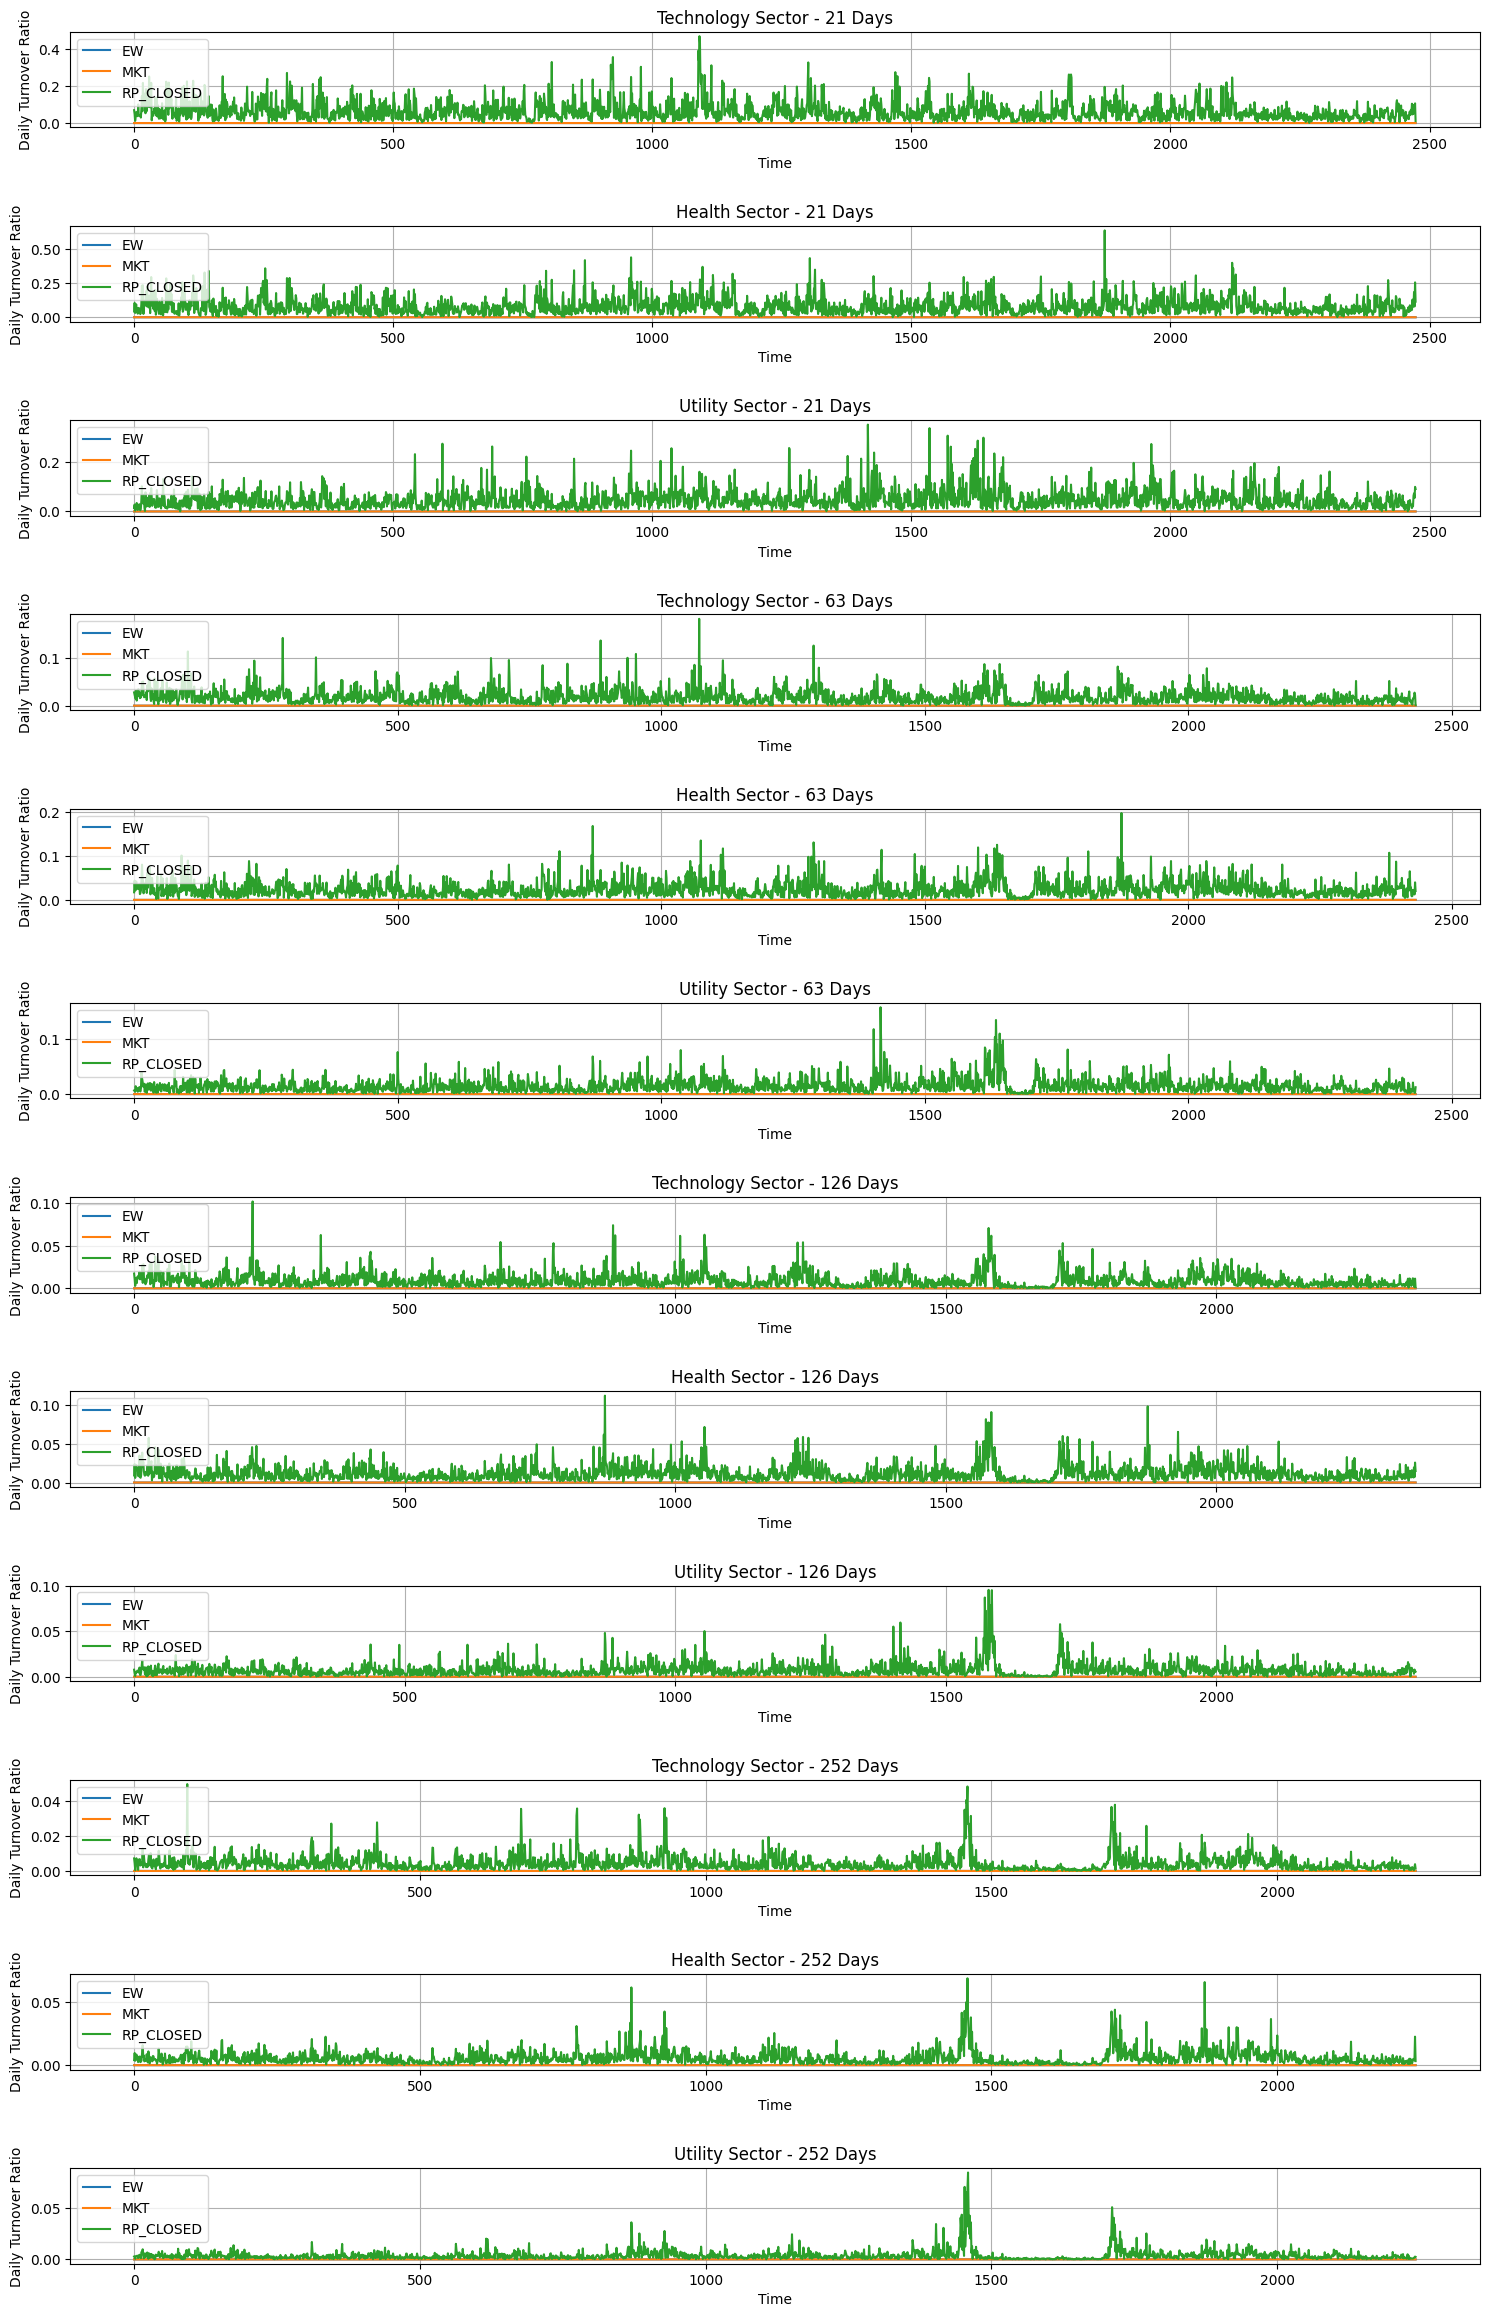

In [ ]:
def plot_daily_turnovers(dfs, titles, figsize=(16, 24)):
    num_dfs = len(dfs)

    fig, axes = plt.subplots(nrows=num_dfs, ncols=1, figsize=figsize)
    fig.tight_layout(pad=5.0)

    for i, (df, title) in enumerate(zip(dfs, titles)):
        ax = axes[i]

        # Plot the daily turnovers for each method
        ax.plot(df['ew'], label='EW')
        ax.plot(df['mkt'], label='MKT')
        ax.plot(df['rp_closed'], label='RP_CLOSED')

        # Customize the chart
        ax.set_title(title)
        ax.set_xlabel('Time')
        ax.set_ylabel('Daily Turnover Ratio')
        ax.legend(loc='upper left')
        ax.grid(True)

    # Display the charts
    plt.show()

# Create a list of turnover DataFrames
turnover_dataframes = list(turnover_dfs.values())

# Update the titles list to match the keys in the turnover_dfs dictionary
titles = [
    'Technology Sector - 21 Days', 'Health Sector - 21 Days', 'Utility Sector - 21 Days',
    'Technology Sector - 63 Days', 'Health Sector - 63 Days', 'Utility Sector - 63 Days',
    'Technology Sector - 126 Days', 'Health Sector - 126 Days', 'Utility Sector - 126 Days',
    'Technology Sector - 252 Days', 'Health Sector - 252 Days', 'Utility Sector - 252 Days'
]

# Call the plot_daily_turnovers function with the turnover_dataframes list and the titles list
plot_daily_turnovers(turnover_dataframes, titles)

